# A real state forectasing project:

## Table of Contents:
1. Intro
2. ETL. We do the loading and cleaning of the data we are going to work with.
3. EDA. We will make an exploratory analysis of the data to see how the different variables behave with respect to the price of the houses.
4. Projections. We will try to project the values of housing prices for the first half of 2022.
5. Conclusions.

## 1. Intro:

Nice to have one...

## 2. ETL process:

In this section we will load the data for the development of the analysis case.

On the one hand we have the data of the housing notices for 2021, which will be loaded from a .sqlite file.

On the other hand we will load the exchange rate quotes for 2021, which will be loaded from a .csv file.

In [175]:
# Comenzaremos cargando los paquetes que vamos a utilizar a lo largo del notebook:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import sqlite3
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set(rc={'figure.figsize':(8,8)})

In [176]:
# Dataframe for the exchange rate:
tc_data = pd.read_excel(
    r"...\RealStateProject\Data\Cotizaciones.xlsx",
    sheet_name='Hoja1'
)

# Dataframe of the properties:
query = "SELECT * FROM data"
con = sqlite3.connect(
    r"...\RealStateProject\Data\UyMontevideo.sqlite"
)

raw_data = pd.read_sql(query,con)
raw_data.head()

,nombre_inmueble,aviso,precio,superficie,tipo,dormitorios,direccion,barrio,negocio,fecha
0,CASAS-ALQUILER-TEMPORAL-PUNTA-COLORADA-034,16579724,U$S 1.750,600 Mts,Casa,2 dormitorios,Av. Primera entre Rambla Costanera y 8 Guazubi...,Punta Colorada,Alquiler temporario,2021-01-03 00:00:00
1,"Alquilo Apto. 2 Dorm. Vista , 2 da Enero y Mar...",16735528,$U 800,None,Apartamento,2 dormitorios,Mi hijo el doctor y En Familia,Punta Del Este,Alquiler temporario,2021-01-03 00:00:00
2,"Casa en Cerro del Burro ""MIRADOR II""",13795860,U$S 100.000,300 Mts,Casa,1 dormitorio,... y Cerro del burro,Piriápolis,Venta,2021-01-03 00:00:00
3,Oficina Alquiler World Trade Center -WTC- Poci...,15655688,U$S 1.600,None,Oficina,None,... y Buceo,Buceo,Alquiler,2021-01-03 00:00:00
4,Terreno en Punta Colorada,12805785,U$S 67.000,615 Mts,Terreno,None,TE201282 y Punta colorada,Punta Colorada,Venta,2021-01-03 00:00:00


In [177]:
print(f'We count with: {raw_data.shape[0]} rows and {raw_data.shape[1]} columns.')

We count with: 96583 rows and 10 columns.


We generate a copy of the original data to work with, in order to make the appropriate transformations without modifying the original data.

In [178]:
data = raw_data
data.head()

,nombre_inmueble,aviso,precio,superficie,tipo,dormitorios,direccion,barrio,negocio,fecha
0,CASAS-ALQUILER-TEMPORAL-PUNTA-COLORADA-034,16579724,U$S 1.750,600 Mts,Casa,2 dormitorios,Av. Primera entre Rambla Costanera y 8 Guazubi...,Punta Colorada,Alquiler temporario,2021-01-03 00:00:00
1,"Alquilo Apto. 2 Dorm. Vista , 2 da Enero y Mar...",16735528,$U 800,None,Apartamento,2 dormitorios,Mi hijo el doctor y En Familia,Punta Del Este,Alquiler temporario,2021-01-03 00:00:00
2,"Casa en Cerro del Burro ""MIRADOR II""",13795860,U$S 100.000,300 Mts,Casa,1 dormitorio,... y Cerro del burro,Piriápolis,Venta,2021-01-03 00:00:00
3,Oficina Alquiler World Trade Center -WTC- Poci...,15655688,U$S 1.600,None,Oficina,None,... y Buceo,Buceo,Alquiler,2021-01-03 00:00:00
4,Terreno en Punta Colorada,12805785,U$S 67.000,615 Mts,Terreno,None,TE201282 y Punta colorada,Punta Colorada,Venta,2021-01-03 00:00:00


The analysis case is delimited to the municipalities B, C, CH and E of Montevideo; therefore, an exclusion list must be generated with all those cities/neighborhoods that are not in that zone.

In [179]:
exclusion_list = [
       'Punta Colorada', 'Punta Del Este', 'Piriápolis', 'Pando', 'Punta Negra','San José', 'Ciudad Del Plata', 'Parque Del Plata',
       'Solís', 'Libertad', 'Playa Hermosa','Atlántida', 'Minas', 'Playa Grande', 'Shangrilá', 'Barra De Carrasco', 'Portezuelo', 'Maldonado',
       'Otra', 'Las Flores', 'Las Piedras', 'B. De Carrasco', 'Colon', 'Sauce De Portezuelo', 'La Teja', 'El Pinar',
       'Punta Fría', 'Costa Azul', 'Villa Española', 'Balneario Kiyú', 'Parque Miramar', 'Barra Del Chuy',
       'San Jacinto', 'Carreta Quemada', 'Playa Verde', 'Lomas De Solymar', 'Ciudad De La Costa', 'La Tahona', 'Salinas',
       'Paso De La Arena', 'Maroñas', 'Villa Biarritz', 'Canelones', 'Solymar', 'La Floresta',
       'Maroñas Curva', 'José Ignacio', 'Pinares', 'Cerro', 'Ecilda Paullier', 'Cerrito', 'Pinamar', 'Las Vegas',
       'Florida', 'Playa Pascual', 'Punta Ballena', 'Lagomar', 'La Barra', 'Villa Rodríguez', 'Sayago', 'Piedras Blancas', 'Pan De Azúcar',
       'Barros Blancos', 'Rivera', 'Paso Molino', 'Las Toscas', 'Barra Santa Lucia', 'Casupá', 'Colonia Nicolich', 'Belvedere',
       'Rafael Perazza', 'Colonia', 'Los Cerrillos', 'Bello Horizonte', 'J. Hipodromo', 'Guazú Virá', 'San Luis', 'Las Acacias',
       'La Pedrera', 'Haras Del Lago', 'El Colorado', 'San José De Carrasco', 'Perez Castellanos',
       'Mal Abrigo', 'Aguas Dulces', 'Melilla', 'Durazno', 'Casabo', 'Santa Lucía', 'Pajas Blancas',
       'Marindia', 'Manantiales', 'Sauce', 'Manga', 'Trinidad', 'Araminda', 'La Paloma', 'Neptunia', 'Punta Del Diablo',
       'Nuevo Paris', 'Lezica', 'Jaureguiberry', 'Santa Ana', 'Médanos De Solymar', 'Cerro Chato', 'Cno. Maldonado', 'Carmelo',
       'Peñarol', 'Nueva Helvecia', 'San Rafael', 'Villa Argentina', 'Parque De Solymar', 'Cuchilla Alta',
       'Paso Carrasco', 'Punta Rieles', 'Progreso', 'Arroyo De La Virgen', 'Juan Lacaze', 'Melo', 'Aguas Corrientes', 'Suárez', 'Solís Chico', 'Polanco', 'La Paz',
       'Santa Rosa', 'San Gregorio De Polanco', 'Castillos', 'Villa Serrana', 'Casavalle', 'San Bautista',
       'Paysandú', 'San Carlos', 'Cerros Azules', 'Abra De Perdomo', 'Fray Bentos', 'Solís De Mataojo', 'Tala', 'Mercedes', 'Salto',
       'Punta Piedras', 'Cabo Polonio', 'Valdense', 'Empalme Olmos', 'Rocha', 'Fraile Muerto', 'Toledo', 'San Antonio',
       'Arachania', 'Tacuarembó', 'Laguna De Los Patos', 'Nueva Palmira', 'Young', 'Balneario Argentino', 'Treinta Y Tres', 'Guichón',
       'Las Garzas', 'La Casilla', 'Lago Merín', 'El Bosque', 'Colinas De Solymar', 'La Coronilla', 'Laguna Garzón',
       'Joaquín Suárez', 'Los Titanes', 'Soca', 'Chuy', 'Colonia Suiza', 'Montes De Solymar', 'Pueblo Edén', 'Fray Marcos', 'Rio Branco',
       'Juan Antonio Artigas', 'Santa Lucía Del Este', 'San Cristóbal', 'Aiguá', 'Fortín De Santa Rosa', 'Rosario', 'Migues', 'Cerrillos', 'José Pedro Varela',
       'Tropas Viejas', 'Juanicó', 'Artigas', 'Andresito', 'Totoral', 'Pinares De Solymar', 'Quebracho', 'Santa Clara Del Olimar', 'La Esmeralda', 'Aguas Blancas',
       'Villa Soriano', 'Cardona', 'La Tuna', 'Vichadero', 'Piedras De Afilar', 'La Arbolada','Otros'
]

# The neighborhoods that do not belong to the municipalities to be studied are eliminated from the original dataframe.
data= data[~data["barrio"].isin(exclusion_list)]
data.head()

,nombre_inmueble,aviso,precio,superficie,tipo,dormitorios,direccion,barrio,negocio,fecha
3,Oficina Alquiler World Trade Center -WTC- Poci...,15655688,U$S 1.600,None,Oficina,None,... y Buceo,Buceo,Alquiler,2021-01-03 00:00:00
6,Oficina Sosa - Local Con Vivienda Alquilado En...,16224275,U$S 125.000,None,Local,None,Oficina Sosa - Local Con Vivienda Alquilado En...,Brazo Oriental,Venta,2021-01-03 00:00:00
10,Excelente Local Amplio - Gran Sótano Centro,16436745,$U 25.000,None,Local,None,Soriano y Julio Herrera Y Obes,Centro,Alquiler,2021-01-03 00:00:00
11,Terreno en el Centro,16703708,U$S 220.000,442 Mts,Terreno,None,Wilson Ferreira Aldunate y Durazno,Centro,Venta,2021-01-03 00:00:00
12,Impecable apartamento en zona privilegiada.,12452693,U$S 380.000,130 Mts,Apartamento,3 dormitorios,Ramon Fernandez y Bulevar Artigas,Punta Carretas,Venta,2021-01-03 00:00:00


In [180]:
data.columns = data.columns.str.strip()
print(data.columns)

Index(['nombre_inmueble', 'aviso', 'precio', 'superficie', 'tipo',
       'dormitorios', 'direccion', 'barrio', 'negocio', 'fecha'],
      dtype='object')


In [181]:
data = data.drop(['nombre_inmueble','direccion'], axis=1 )
data.head()

,aviso,precio,superficie,tipo,dormitorios,barrio,negocio,fecha
3,15655688,U$S 1.600,None,Oficina,None,Buceo,Alquiler,2021-01-03 00:00:00
6,16224275,U$S 125.000,None,Local,None,Brazo Oriental,Venta,2021-01-03 00:00:00
10,16436745,$U 25.000,None,Local,None,Centro,Alquiler,2021-01-03 00:00:00
11,16703708,U$S 220.000,442 Mts,Terreno,None,Centro,Venta,2021-01-03 00:00:00
12,12452693,U$S 380.000,130 Mts,Apartamento,3 dormitorios,Punta Carretas,Venta,2021-01-03 00:00:00


We will identify the published housing/property types and map them with numerical values for further work:

In [182]:
data["tipo"].unique()

array(['Oficina', 'Local', 'Terreno', 'Apartamento', 'Casa', 'Comercio',
       'Garage', 'Piezas', 'Edificio', 'Campo', None], dtype=object)

In [183]:
# Replace None values with '0'
data['tipo'] = data['tipo'].fillna('0')

# Define a dictionary mapping each unique value in 'tipo' to a number from 1 to n
tipo_mapping = {'0': 0, 'Oficina': 1, 'Local': 2, 'Terreno': 3, 'Apartamento': 4, 
                'Casa': 5, 'Comercio': 6, 'Garage': 7, 'Piezas': 8, 
                'Edificio': 9, 'Campo': 10}

# Use the map function to replace the values in 'tipo' with their corresponding numbers
data['tipo'] = data['tipo'].map(tipo_mapping)

data["tipo"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  0], dtype=int64)

In [184]:
data["dormitorios"].unique()

array([None, '3 dormitorios', '2 dormitorios', 'Monoambiente',
       'más de 4 dormitorios', '4 dormitorios', '1 dormitorio', '1 Baños'],
      dtype=object)

In [185]:
# The bathroom should not be classified as a bedroom and therefore we remove it.
data = data[~data['dormitorios'].str.contains('1 Baños', case=False, na=False)]

# We clean the field 'bedrooms', it is convenient that it is a numerical variable and not categorical.

def dormitorios(col):
    if col == '4 dormitorios':
        return 4
    elif col == '3 dormitorios':
        return 3
    elif col == '2 dormitorios':
        return 2
    elif col == '1 dormitorio':
        return 1
    elif col == 'Monoambiente':
        return 1
    elif col == 'más de 4 dormitorios':
        return 5
    elif col is None:
        return 0
    else:
        return 0

data['dormitorios'] = data['dormitorios'].apply(dormitorios)

data.head()

,aviso,precio,superficie,tipo,dormitorios,barrio,negocio,fecha
3,15655688,U$S 1.600,None,1,0,Buceo,Alquiler,2021-01-03 00:00:00
6,16224275,U$S 125.000,None,2,0,Brazo Oriental,Venta,2021-01-03 00:00:00
10,16436745,$U 25.000,None,2,0,Centro,Alquiler,2021-01-03 00:00:00
11,16703708,U$S 220.000,442 Mts,3,0,Centro,Venta,2021-01-03 00:00:00
12,12452693,U$S 380.000,130 Mts,4,3,Punta Carretas,Venta,2021-01-03 00:00:00


In [186]:
data["barrio"].unique()

array(['Buceo', 'Brazo Oriental', 'Centro', 'Punta Carretas',
       'Ciudad Vieja', 'Pocitos Nuevo', 'Malvin', 'Puerto Buceo',
       'Punta Gorda', 'Prado', 'La Comercial', 'Pocitos', 'Carrasco',
       'Aguada', 'Tres Cruces', 'Golf', 'Cordon', 'Union', 'Palermo',
       'La Blanqueada', 'Parque Batlle', 'Bella Vista', 'Reducto',
       'Parque Rodo', 'Jacinto Vera', 'Carrasco Norte', 'Capurro', 'Goes',
       'Larrañaga', 'Villa Dolores', 'Malvin Norte', 'Prado Norte',
       'Barrio Sur', 'Atahualpa', 'Cno. Carrasco', 'Nuevo Centro',
       'Aires Puros', 'Villa Muñoz', 'La Figurita', 'Ituzaingo',
       'Arroyo Seco', 'Bolivar', None], dtype=object)

In [187]:
data.tail()

,aviso,precio,superficie,tipo,dormitorios,barrio,negocio,fecha
96567,18245104,$U 21.000,None,4,1,Pocitos,Alquiler,2021-12-07 00:00:00
96570,15133380,U$S 160.000,None,4,3,Prado,Venta,2021-12-07 00:00:00
96573,17985809,U$S 87.000,39 Mts,4,1,Parque Batlle,Venta,2021-12-07 00:00:00
96575,https://www.gallito.com.uy/tel:097122916,None,None,0,0,None,None,2021-12-07 00:00:00
96576,18639726,$U 13.000,None,4,1,Prado,Alquiler,2021-12-07 00:00:00


We can see that in 'neighborhood' and 'warning' there are values that are not desired since they have no additional information. We will proceed to clean/filter them from our dataframe.

In [188]:
data = data[~data['aviso'].str.startswith('https://www.')]
data["barrio"].unique()

array(['Buceo', 'Brazo Oriental', 'Centro', 'Punta Carretas',
       'Ciudad Vieja', 'Pocitos Nuevo', 'Malvin', 'Puerto Buceo',
       'Punta Gorda', 'Prado', 'La Comercial', 'Pocitos', 'Carrasco',
       'Aguada', 'Tres Cruces', 'Golf', 'Cordon', 'Union', 'Palermo',
       'La Blanqueada', 'Parque Batlle', 'Bella Vista', 'Reducto',
       'Parque Rodo', 'Jacinto Vera', 'Carrasco Norte', 'Capurro', 'Goes',
       'Larrañaga', 'Villa Dolores', 'Malvin Norte', 'Prado Norte',
       'Barrio Sur', 'Atahualpa', 'Cno. Carrasco', 'Nuevo Centro',
       'Aires Puros', 'Villa Muñoz', 'La Figurita', 'Ituzaingo',
       'Arroyo Seco', 'Bolivar'], dtype=object)

We will analyze what happens with the surface field, we will have to standardize the measurement units of the properties in order to be able to compare them:

In [189]:
data["superficie"].unique()

array([None, '442 Mts', '130 Mts', '75 Mts', '30 Mts', '96 Mts', '85 Mts',
       '249 Mts', '86 Mts', '140 Mts', '46 Mts', '215 Mts', '44 Mts',
       '58 Mts', '1 Baños', '10 Mts', '70 Mts', '580 Mts', '1000 Mts',
       '339 Mts', '750 Mts', '35 Mts', '60 Mts', '26 Mts', '65 Mts',
       '87 Mts', '29 Mts', '31 Mts', '192 Mts', '48 Mts', '190 Mts',
       '220 Mts', '260 Mts', '300 Mts', '92 Mts', '168 Mts', '915 Mts',
       '43 Mts', '6050 Mts', '320 Mts', '180 Mts', '59 Mts', '55 Mts',
       '112 Mts', '118 Mts', '40 Mts', '45 Mts', '90 Mts', '350 Mts',
       '121 Mts', '150 Mts', '230 Mts', '600 Mts', '67 Mts', '37 Mts',
       '76 Mts', '52 Mts', '69 Mts', '1576 Mts', '115 Mts', '250 Mts',
       '33 Mts', '57 Mts', '1350 Mts', '80 Mts', '50 Mts', '100 Mts',
       '430 Mts', '310 Mts', '440 Mts', '47 Mts', '165 Mts', '41 Mts',
       '480 Mts', '51 Mts', '138 Mts', '258 Mts', '53 Mts', '1 Mts',
       '675 Mts', '195 Mts', '49 Mts', '73 Mts', '178 Mts', '84 Mts',
       '71 

In [190]:
# Observe if there are values that are not in meters
data[data['superficie'].str.contains('Mts')==False]['superficie'].value_counts()

superficie
1 Baños           64
2 Baños           41
Más de 3 baños    29
Monoambiente       9
1244 Has.          8
3 Baños            8
3 Has.             4
150 Has.           4
397 Has.           4
1 Has.             4
962 Has.           3
2700 Has.          3
200 Has.           2
575 Has.           1
240 Has.           1
246 Has.           1
180 Has.           1
218 Has.           1
580 Has.           1
3234 Has.          1
700 Has.           1
222 Has.           1
250 Has.           1
317 Has.           1
2800 Has.          1
311 Has.           1
342 Has.           1
1000 Has.          1
2000 Has.          1
315 Has.           1
270 Has.           1
300 Has.           1
856 Has.           1
Name: count, dtype: int64

We will have to work some more with the column 'surface', we will replace the values that are wrongly assigned as: Bathrooms, Single occupancy, etc. by values = 0, and then filter them since they would not be giving us information. And finally convert the Has in m2.

In [191]:
# It can be observed that the surface area column has values in different units of measurement, such as Mts and Has and even values that do not correspond to the surface area column.
# column, such as the number of bathrooms and monoambiente. It is for this reason that a value of 0 will be assigned to those values that do not correspond to this column.
# (i.e. all those that are not in Mts or Has).

data['superficie'][data['superficie']== '1 Baños'] = 0
data['superficie'][data['superficie']== '2 Baños'] = 0
data['superficie'][data['superficie']== '3 Baños'] = 0
data['superficie'][data['superficie']== 'Más de 3 Baños'] = 0
data['superficie'][data['superficie']== 'Monoambiente'] = 0

C:\Users\andre\AppData\Local\Temp\ipykernel_5460\4125131165.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['superficie'][data['superficie']== '2 Baños'] = 0
C:\Users\andre\AppData\Local\Temp\ipykernel_5460\4125131165.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['superficie'][data['superficie']== '3 Baños'] = 0


C:\Users\andre\AppData\Local\Temp\ipykernel_5460\4125131165.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['superficie'][data['superficie']== 'Más de 3 Baños'] = 0
C:\Users\andre\AppData\Local\Temp\ipykernel_5460\4125131165.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['superficie'][data['superficie']== 'Monoambiente'] = 0


In [192]:
# It can be seen that in the surface area column there is data expressed in hectares instead of meters. The data in hectares will be converted to square meters below.
data[data['superficie'].str.contains('Mts')==False]['superficie'].value_counts()

superficie
Más de 3 baños    29
1244 Has.          8
150 Has.           4
397 Has.           4
1 Has.             4
3 Has.             4
962 Has.           3
2700 Has.          3
200 Has.           2
250 Has.           1
222 Has.           1
700 Has.           1
580 Has.           1
2800 Has.          1
218 Has.           1
180 Has.           1
246 Has.           1
317 Has.           1
2000 Has.          1
311 Has.           1
342 Has.           1
1000 Has.          1
3234 Has.          1
315 Has.           1
575 Has.           1
240 Has.           1
300 Has.           1
270 Has.           1
856 Has.           1
Name: count, dtype: int64

In [193]:
col = ['aviso','precio', 'superficie', 'tipo', 'dormitorios', 'barrio', 'negocio', 'fecha']

data = data.dropna(subset=col)

data.head()

,aviso,precio,superficie,tipo,dormitorios,barrio,negocio,fecha
11,16703708,U$S 220.000,442 Mts,3,0,Centro,Venta,2021-01-03 00:00:00
12,12452693,U$S 380.000,130 Mts,4,3,Punta Carretas,Venta,2021-01-03 00:00:00
14,16660467,U$S 129.000,75 Mts,4,2,Ciudad Vieja,Venta,2021-01-03 00:00:00
15,13853448,U$S 115.000,30 Mts,4,1,Punta Carretas,Venta,2021-01-03 00:00:00
17,15079669,U$S 345.000,96 Mts,4,3,Malvin,Venta,2021-01-03 00:00:00


In [194]:
# We define a function to convert Has to m2:

# First we define how we identify those values expressed in Ha.
def convertir_has_a_m2(col):
    # Check if col is a string before checking if 'Has.' is in it
    if isinstance(col, str) and 'Has.' in col:
        # Extract the number of has and convert it to m².
        has_value = float(col.split()[0])
        m2_value = has_value * 10000
        return f"{m2_value} Mts"
    else:
        # Keep values in m² unchanged.
        return col

data['superficie'] = data['superficie'].apply(convertir_has_a_m2)
data.head()

,aviso,precio,superficie,tipo,dormitorios,barrio,negocio,fecha
11,16703708,U$S 220.000,442 Mts,3,0,Centro,Venta,2021-01-03 00:00:00
12,12452693,U$S 380.000,130 Mts,4,3,Punta Carretas,Venta,2021-01-03 00:00:00
14,16660467,U$S 129.000,75 Mts,4,2,Ciudad Vieja,Venta,2021-01-03 00:00:00
15,13853448,U$S 115.000,30 Mts,4,1,Punta Carretas,Venta,2021-01-03 00:00:00
17,15079669,U$S 345.000,96 Mts,4,3,Malvin,Venta,2021-01-03 00:00:00


In [195]:
# Function to extract only numeric values
def extrae_num(col):
    # Check if col is a string before using re.search
    if isinstance(col, str):
        # Use a regular expression to extract the numeric values
        match = re.search(r'\d+(\.\d+)?', col)
        if match:
            return match.group()
    # Return None for non-string values
    return None

# Apply the function to extract numerical values to the column 'area'.
data['superficie'] = data['superficie'].apply(extrae_num)

data.head()

,aviso,precio,superficie,tipo,dormitorios,barrio,negocio,fecha
11,16703708,U$S 220.000,442,3,0,Centro,Venta,2021-01-03 00:00:00
12,12452693,U$S 380.000,130,4,3,Punta Carretas,Venta,2021-01-03 00:00:00
14,16660467,U$S 129.000,75,4,2,Ciudad Vieja,Venta,2021-01-03 00:00:00
15,13853448,U$S 115.000,30,4,1,Punta Carretas,Venta,2021-01-03 00:00:00
17,15079669,U$S 345.000,96,4,3,Malvin,Venta,2021-01-03 00:00:00


In [196]:
# We change the data type of the date field in dataframes to merge it with the date field for the quotation of the TC (Purchase):
data['fecha'] = data['fecha'].astype('datetime64[ns]')
tc_data['fecha'] = tc_data['fecha'].astype('datetime64[ns]')

# We join the dataframes using as 'index' the date field:
data = pd.merge(data, tc_data, on='fecha', how='inner')
data.head()

,aviso,precio,superficie,tipo,dormitorios,barrio,negocio,fecha,Compra
0,16703708,U$S 220.000,442,3,0,Centro,Venta,2021-01-03,"42,1600"
1,12452693,U$S 380.000,130,4,3,Punta Carretas,Venta,2021-01-03,"42,1600"
2,16660467,U$S 129.000,75,4,2,Ciudad Vieja,Venta,2021-01-03,"42,1600"
3,13853448,U$S 115.000,30,4,1,Punta Carretas,Venta,2021-01-03,"42,1600"
4,15079669,U$S 345.000,96,4,3,Malvin,Venta,2021-01-03,"42,1600"


In [197]:
# Define a function to extract the currency symbol and number from a string
def split_currency_number(value):
    match = re.match(r'([^\d]*)(\d+\.?\d*)', value)
    return match.groups() if match else (None, None)

# Apply the function to the 'precio' column
data[['divisa', 'valor']] = data['precio'].apply(split_currency_number).apply(pd.Series)

# Convert 'numero' to a numeric type, removing dots
data['valor'] = data['valor'].str.replace('.', '').astype(int)

# Replace commas with dots in 'Compra' column
data['Compra'] = data['Compra'].astype(str).str.replace(',', '.')

# Cast values to float
data['Compra'] = data['Compra'].astype(float)
data['valor'] = data['valor'].astype(float)

# Now we convert the values of '$U' to 'U$S' and save the data in a new column:

# Suppose df is your DataFrame.
data['valor_usd'] = data.apply(lambda row: row['valor'] / row['Compra']  if row['divisa'] == ' $U ' else row['valor'], axis=1)
data['valor_usd'] = data['valor_usd'].astype(int)

data.head()

,aviso,precio,superficie,tipo,dormitorios,barrio,negocio,fecha,Compra,divisa,valor,valor_usd
0,16703708,U$S 220.000,442,3,0,Centro,Venta,2021-01-03,42.16,U$S,220000.0,220000
1,12452693,U$S 380.000,130,4,3,Punta Carretas,Venta,2021-01-03,42.16,U$S,380000.0,380000
2,16660467,U$S 129.000,75,4,2,Ciudad Vieja,Venta,2021-01-03,42.16,U$S,129000.0,129000
3,13853448,U$S 115.000,30,4,1,Punta Carretas,Venta,2021-01-03,42.16,U$S,115000.0,115000
4,15079669,U$S 345.000,96,4,3,Malvin,Venta,2021-01-03,42.16,U$S,345000.0,345000


In [198]:
data = data.drop(['precio', 'Compra', 'divisa', 'valor'], axis=1 )
data.head()

,aviso,superficie,tipo,dormitorios,barrio,negocio,fecha,valor_usd
0,16703708,442,3,0,Centro,Venta,2021-01-03,220000
1,12452693,130,4,3,Punta Carretas,Venta,2021-01-03,380000
2,16660467,75,4,2,Ciudad Vieja,Venta,2021-01-03,129000
3,13853448,30,4,1,Punta Carretas,Venta,2021-01-03,115000
4,15079669,96,4,3,Malvin,Venta,2021-01-03,345000


## 3. EDA:
We will start our exploratory data analysis in this section. We will take some points of reference such as that the variable we are interested in analyzing is price, and that we have some columns/variables that are categorical:
'tipo', 'dormitorios', 'barrio' and 'negocio'.

Te variables 'tipo' and 'dormitorios' for convenience throughout the ETL we mapped them to numerical values, now as a reminder of how we did it we have to:

tipo_mapping = {'0': 0, 'Oficina': 1, 'Local': 2, 'Terreno': 3, 'Apartamento': 4, 'Casa': 5, 'Comercio': 6, 'Garage': 7, 'Piezas': 8, 'Edificio': 9, 'Campo': 10}

dormitorios = {'más de 4 dormitorios': 5, '4 dormitorios': 4, '3 dormitorios': 3, '2 dormitorios': 2, '1 dormitorios': 1, 'Monoambiente': 1, None: 0 }

In the case of 'dormitorios' we will make some clarifications, for example in the case of: 'más de 4 dormitorios' as the information is inaccurate we appeal to the logic, then 'más de 4 dormitorios' is 5 so we assign the value.
For the cases of: '1 dormitorios' and 'Monoambiente' we understand that we must assign the value 1 since regardless of the layout of the property (walls and physical divisions of bedrooms) we assume that a person sleeps in a single room. Finally, in case there is no bedroom information, we assign the value 0 (Case of land).

### We will analyze how the prices in dollars are distributed according to the published ads:

It is interesting to see how the average prices of the ads are distributed along the municipalities and in particular the neighborhoods there.

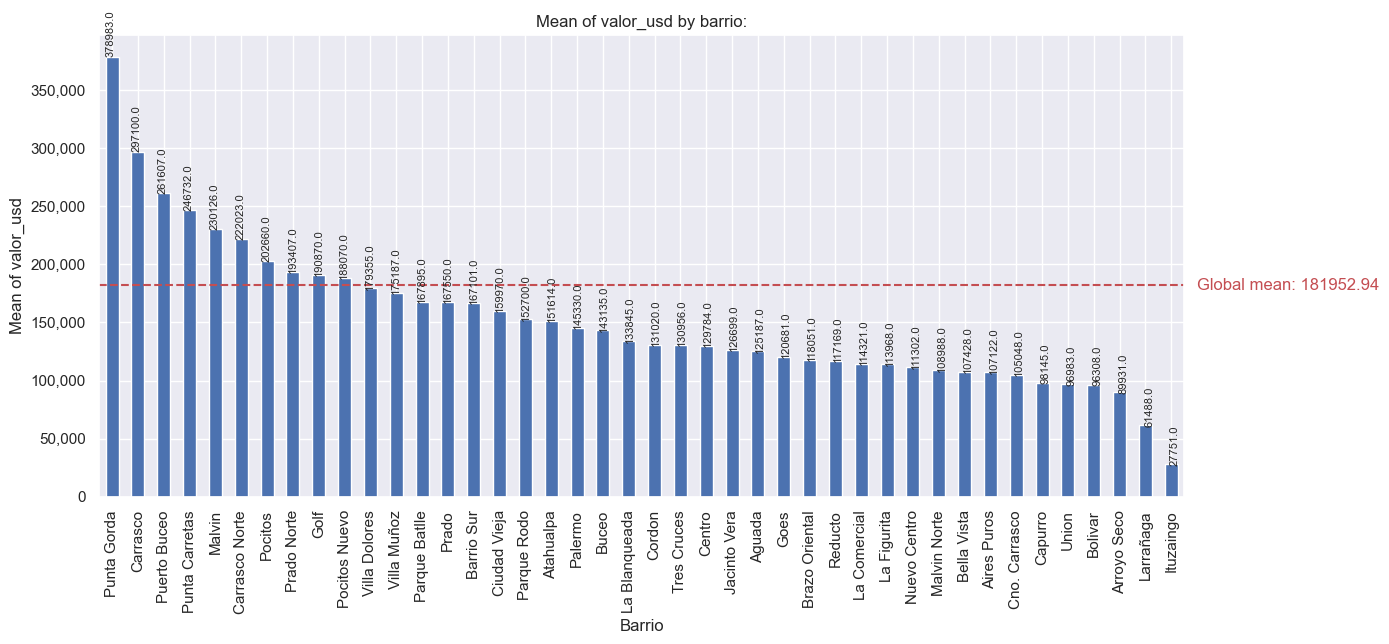

In [199]:
# Calculates the average of 'usd_value' by 'neighborhood'.
mean_valor_usd = data.groupby('barrio')['valor_usd'].mean().round()

# Sort values in descending order
mean_valor_usd = mean_valor_usd.sort_values(ascending=False)

# Calculates the average of all values
mean = data['valor_usd'].mean()

# Create a bar chart
fig, ax = plt.subplots(figsize=(14, 6))
mean_valor_usd.plot(kind='bar', ax=ax)

# Adds a horizontal line for the average of all the values
ax.axhline(y=mean, color='r', linestyle='--')

# Adds a label for the stocking line
ax.text(len(mean_valor_usd), mean, f'Global mean: {mean:.2f}', color='r', va='center')

# Sets the title and labels of the axes.
ax.set_title('Mean of valor_usd by barrio:')
ax.set_xlabel('Barrio')
ax.set_ylabel('Mean of valor_usd')

# Rotate the x-axis labels to vertical
plt.xticks(rotation='vertical')

# Sets the size of the y-axis labels.
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Add the labels of the values in the bars.
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005), rotation=90, fontsize=8)

# Shows the graph
plt.show()

We can see that the average of the published ads is in the U$D 181,952.94 and that the neighborhoods that are above the average are Carrasco, Carrasco Norte, Malvin, Punta Gorda, Punta Carretas, Puerto Buceo, among others. However, this is not entirely descriptive since we have ads of various types, being the most typical ones sale and rental. It will be convenient to study what happens in each case.

### We begin by analyzing the price per business within the advertisements:

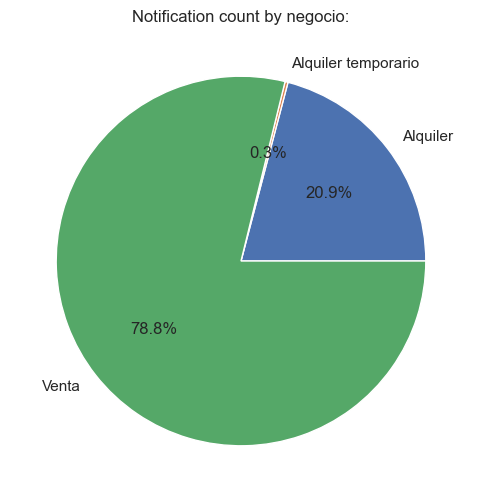

In [200]:
# We grouped ad data by business for graphing:
counts = data.groupby('negocio')['aviso'].nunique()

# We plot:
plt.figure(figsize=(10,6))
plt.pie(counts, labels = counts.index, autopct='%1.1f%%')
plt.title('Notification count by negocio:')
plt.show()

As we can see, of the total number of ads, most are for sales (almost 80%), while almost 21% are for rentals. This indicates that a little more than 21% of the property owners who publish ads are interested in generating profitability without losing their status as owners, while almost 80% are looking to obtain some income from the sale of their property.

It will be interesting to analyze what happens with the ads published for the different businesses offered in the ads, in particular what is the average value in U$D per neighborhood for each business:

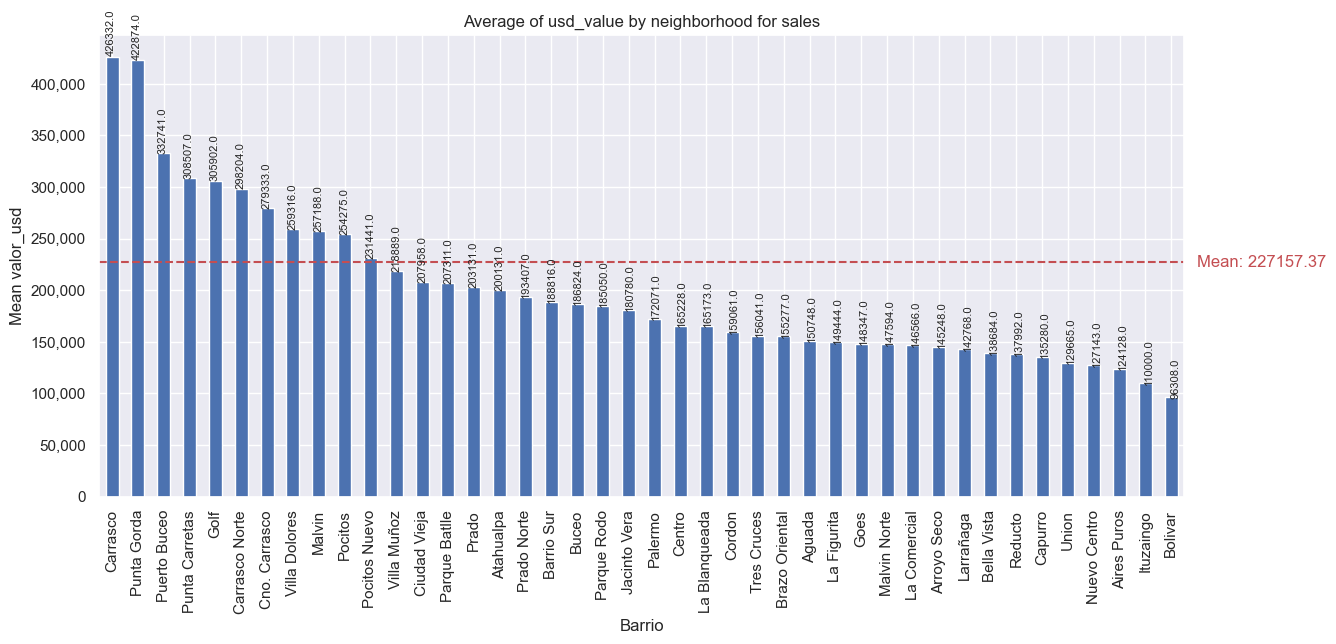

In [201]:
# Filter data where 'business' is 'sale'.
data_v = data[data['negocio'] == 'Venta']

# Calculates the average of 'usd_value' by 'neighborhood'.
mean_valor_usd = data_v.groupby('barrio')['valor_usd'].mean().round()

# Sort values in descending order
mean_valor_usd = mean_valor_usd.sort_values(ascending=False)

# Calculates the average of all values
mean = data_v['valor_usd'].mean()

# Create a bar chart
fig, ax = plt.subplots(figsize=(14, 6))
mean_valor_usd.plot(kind='bar', ax=ax)

# Adds a horizontal line for the average of all the values
ax.axhline(y=mean, color='r', linestyle='--')

# Adds a label for the stocking line
ax.text(len(mean_valor_usd), mean, f'Mean: {mean:.2f}', color='r', va='center')

# Sets the title and labels of the axes.
ax.set_title('Average of usd_value by neighborhood for sales')
ax.set_xlabel('Barrio')
ax.set_ylabel('Mean valor_usd')

# Rotate the x-axis labels to vertical
plt.xticks(rotation='vertical')

# Sets the size of the y-axis labels.
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Add the labels of the values in the bars.
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005), rotation=90, fontsize=8)

# Shows the graph
plt.show()

We can observe that for the real estate sale business the average price of the analyzed municipalities is U$D 227,157, and that the neighborhoods with average prices above the average are:

Carrasco, Carrasco Norte, Cno Carrasco, Golf, Malvin, Pocitos, Puerto de Buceo, Punta Carretas, Punta Gorda, Villa dolores.

While the neighborhoods with the highest averages are: Carrasco, Punta Gorda and Puerto Buceo.

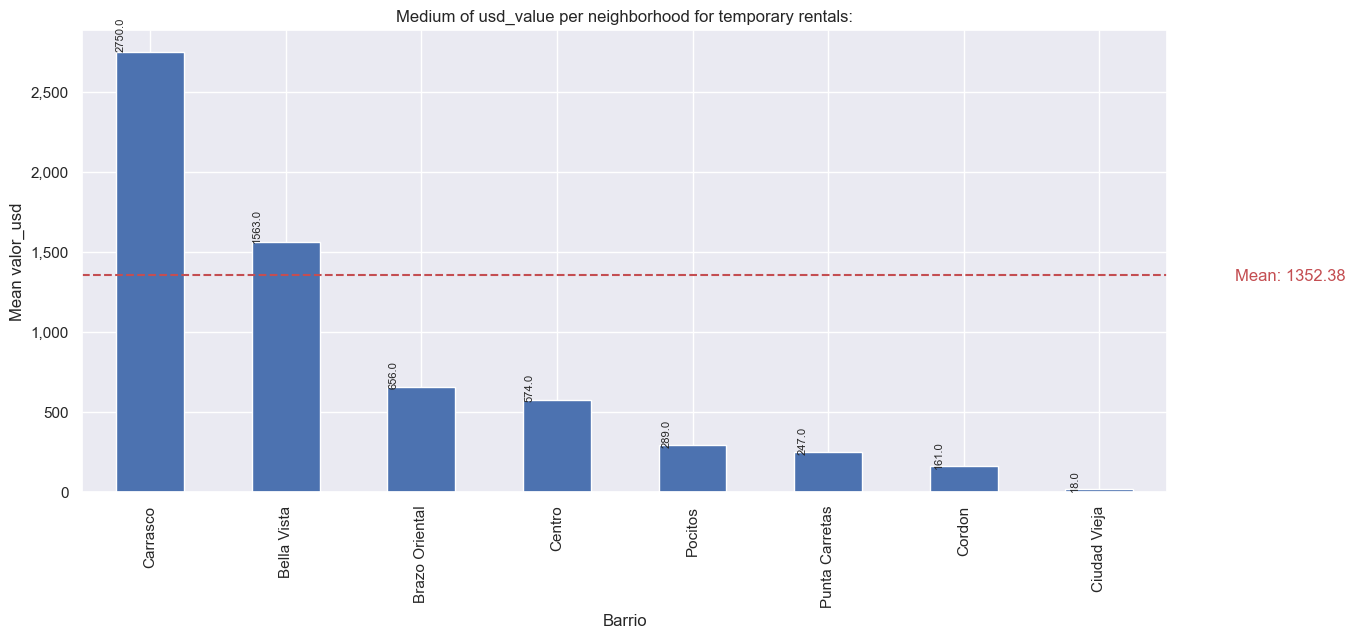

In [202]:
# Filter data where 'business' is 'Temporary rental'.
data_at = data[data['negocio'] == 'Alquiler temporario']

# Calculates the average of 'usd_value' by 'neighborhood'.
mean_valor_usd = data_at.groupby('barrio')['valor_usd'].mean().round()

# Sort values in descending order
mean_valor_usd = mean_valor_usd.sort_values(ascending=False)

# Calculates the average of all values
mean = data_at['valor_usd'].mean()

# Create a bar chart
fig, ax = plt.subplots(figsize=(14, 6))
mean_valor_usd.plot(kind='bar', ax=ax)

# Adds a horizontal line for the average of all the values
ax.axhline(y=mean, color='r', linestyle='--')

# Adds a label for the stocking line
ax.text(len(mean_valor_usd), mean, f'Mean: {mean:.2f}', color='r', va='center')

# Sets the title and labels of the axes.
ax.set_title('Medium of usd_value per neighborhood for temporary rentals:')
ax.set_xlabel('Barrio')
ax.set_ylabel('Mean valor_usd')

# Rotate the x-axis labels to vertical
plt.xticks(rotation='vertical')

# Sets the size of the y-axis labels.
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Add the labels of the values in the bars.
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005), rotation=90, fontsize=8)

# Shows the graph
plt.show()

In the case of temporary rentals, the offer is more reduced and we see that Carrasco repeats again above the average, which in this case is U$D 1352.

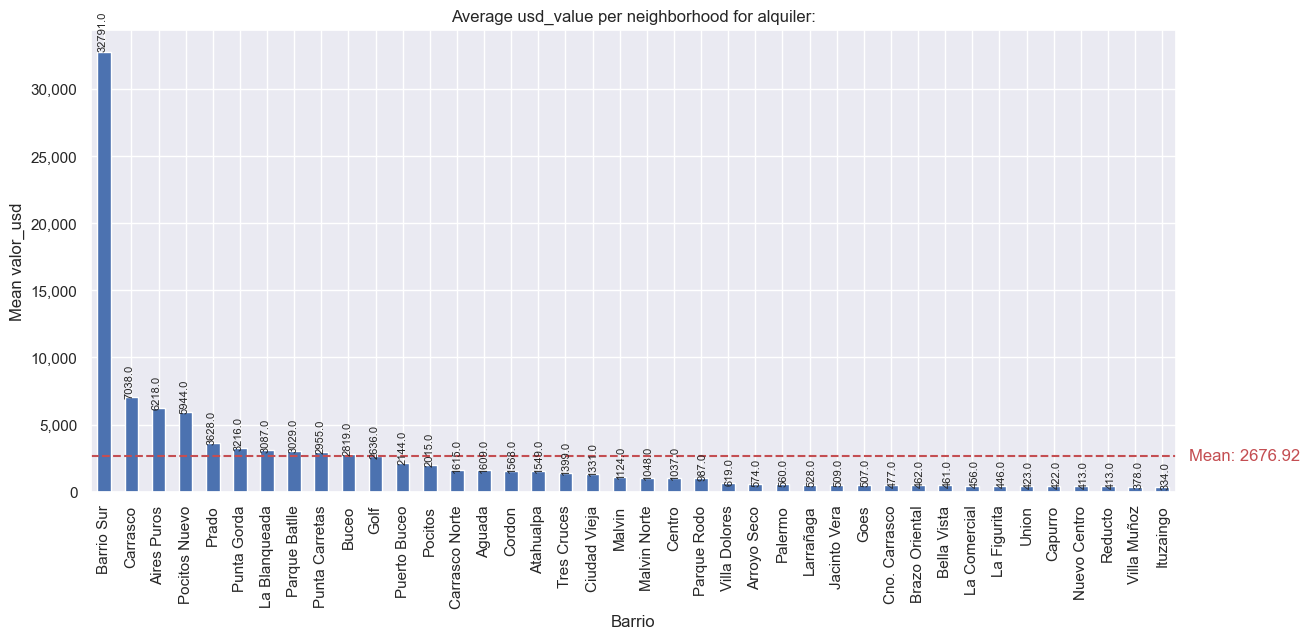

In [203]:
# Filter data where 'business' is 'Rent'.
data_a = data[data['negocio'] == 'Alquiler']

# Calculates the average of 'usd_value' by 'neighborhood'.
mean_valor_usd = data_a.groupby('barrio')['valor_usd'].mean().round()

# Sort values in descending order
mean_valor_usd = mean_valor_usd.sort_values(ascending=False)

# Calculates the average of all values
mean = data_a['valor_usd'].mean()

# Create a bar chart
fig, ax = plt.subplots(figsize=(14, 6))
mean_valor_usd.plot(kind='bar', ax=ax)

# Adds a horizontal line for the average of all the values
ax.axhline(y=mean, color='r', linestyle='--')

# Adds a label for the stocking line
ax.text(len(mean_valor_usd), mean, f'Mean: {mean:.2f}', color='r', va='center')

# Sets the title and labels of the axes.
ax.set_title('Average usd_value per neighborhood for alquiler:')
ax.set_xlabel('Barrio')
ax.set_ylabel('Mean valor_usd')

# Rotate the x-axis labels to vertical
plt.xticks(rotation='vertical')

# Sets the size of the y-axis labels.
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Add the labels of the values in the bars.
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005), rotation=90, fontsize=8)

# Shows the graph
plt.show()

If we analyze the rents of the municipalities that we took, the neighborhood: Barrio Sur is well above the average, surely there is to rent some property for commercial purposes in that neighborhood that has triggered the average rental value in that area.

If we leave aside the atypical case of Barrio Sur, we have that Carrasco repeats again as a neighborhood with average values above the average (In this case the global average of the rents was located in U$D 2676) and that additionally appear Pocitos Nuevo, Aires Puros and some other neighborhoods very close to the average like Punta Gorda, Prado, etc.

### We will analyze the average prices per neighborhood by surface area (m2):

In this section we are interested in knowing how the average footage of the properties offered in the ads is distributed in each neighborhood:

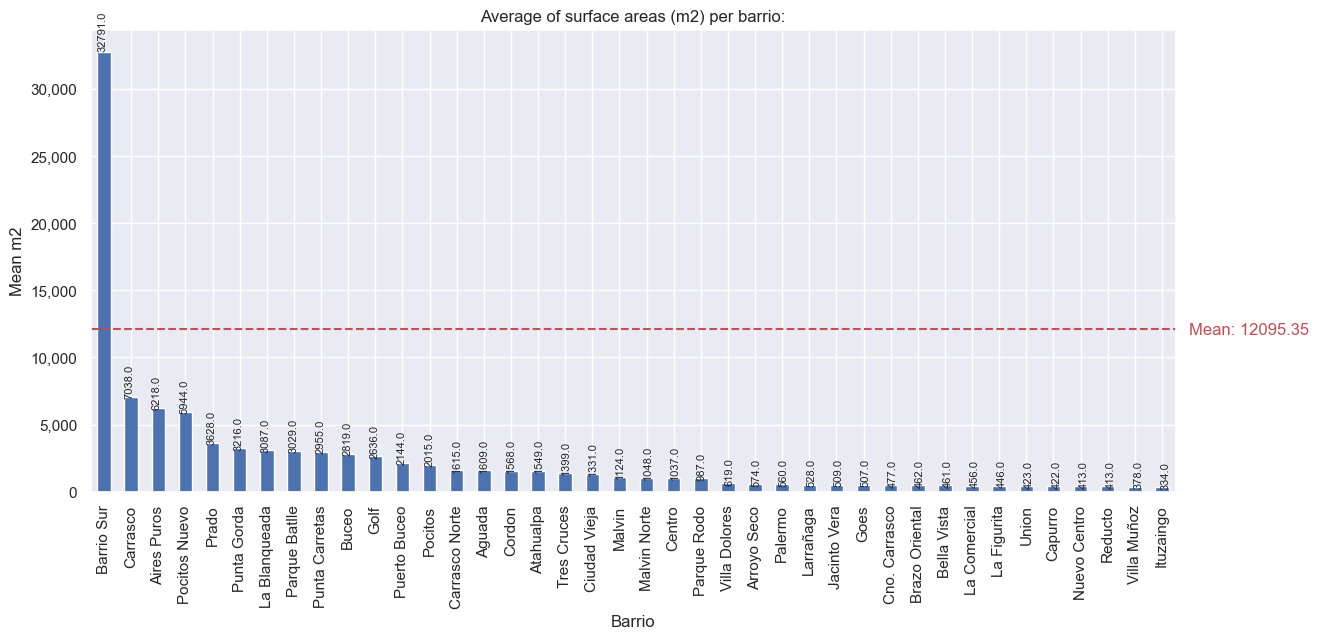

In [204]:
# We change the empty values of the 'surface' column and check that the surface values are integer values:
data['superficie'] = data['superficie'].replace([np.inf, -np.inf], np.nan).fillna(0).astype(float).astype(int)

# Calculates the average of 'usd_value' by 'neighborhood'.
mean_m2 = data.groupby('barrio')['superficie'].mean().round()

# Sort values in descending order
mean_m2 = mean_m2.sort_values(ascending=False)

# Calculates the average of all values
mean = data['superficie'].mean()

# Create a bar chart
fig, ax = plt.subplots(figsize=(14, 6))
mean_valor_usd.plot(kind='bar', ax=ax)

# Adds a horizontal line for the average of all the values
ax.axhline(y=mean, color='r', linestyle='--')

# Adds a label for the stocking line
ax.text(len(mean_valor_usd), mean, f'Mean: {mean:.2f}', color='r', va='center')

# Sets the title and labels of the axes.
ax.set_title('Average of surface areas (m2) per barrio:')
ax.set_xlabel('Barrio')
ax.set_ylabel('Mean m2')

# Rotate the x-axis labels to vertical
plt.xticks(rotation='vertical')

# Sets the size of the y-axis labels.
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Add the labels of the values in the bars.
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005), rotation=90, fontsize=8)

# Shows the graph
plt.show()

At first sight we see that we have data of some properties that have very large extensions in m2, perhaps it would be convenient to start filtering the surfaces and the type of property of each ad.

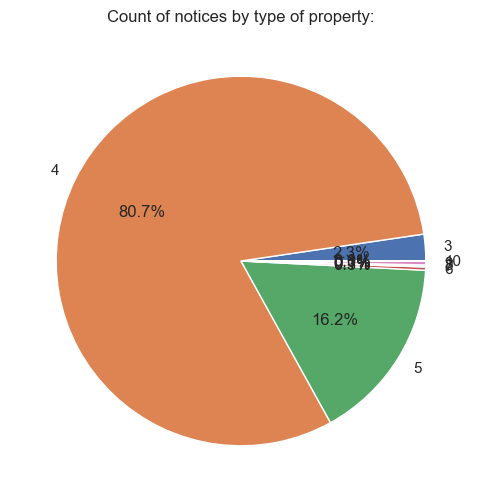

In [205]:
# We grouped ad data by business for graphing:
counts = data.groupby('tipo')['aviso'].nunique()

# We plot:
plt.figure(figsize=(10,6))
plt.pie(counts, labels = counts.index, autopct='%1.1f%%')
plt.title('Count of notices by type of property:')
plt.show()

Recalling the mapping we did in the ETL:

tipo_mapping = {'0': 0, 'Oficina': 1, 'Local': 2, 'Terreno': 3, 'Apartamento': 4, 'Casa': 5, 'Comercio': 6, 'Garage': 7, 'Piezas': 8, 'Edificio': 9, 'Campo': 10}

We can see that we have a majority of the ads concentrated in apartments and houses. We will filter the data set to see what happens in the rest.

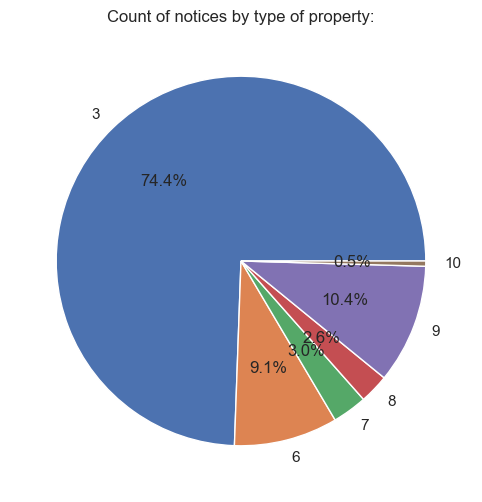

In [206]:
# We filter the ads for Apartments and Houses:
data_tipo = data[~data['tipo'].isin([4, 5])]

# We grouped ad data by business for graphing:
counts = data_tipo.groupby('tipo')['aviso'].nunique()

# We plot:
plt.figure(figsize=(10,6))
plt.pie(counts, labels = counts.index, autopct='%1.1f%%')
plt.title('Count of notices by type of property:')
plt.show()

From the subset of data we can see that the most important are land, commercial and building. These ads have a very large surface which distorts the analysis for the moment, so in principle we will exclude these ads as atypical data and we will work with Houses and Apartments, which are the most abundant ads in the sample.

We will first analyze this proportion within the reduced sample and then move on to the surface area analysis:

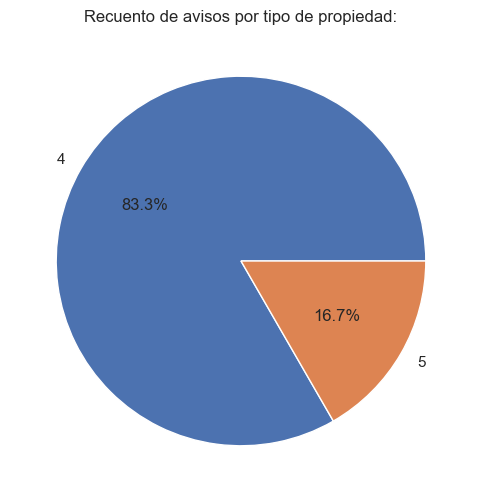

In [207]:
# Filter rows where 'tipo' is 4 or 5
data_ca = data[data['tipo'].isin([4, 5])]

# Group 'aviso' by 'tipo' and count unique values
counts = data_ca.groupby('tipo')['aviso'].nunique()

# Plot
plt.figure(figsize=(10,6))
plt.pie(counts, labels = counts.index, autopct='%1.1f%%')
plt.title('Recuento de avisos por tipo de propiedad:')
plt.show()

In [208]:
data_ca['tipo'].unique()

array([4, 5], dtype=int64)

C:\Users\andre\AppData\Local\Temp\ipykernel_5460\673892236.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ca['superficie'] = data_ca['superficie'].replace([np.inf, -np.inf], np.nan).fillna(0).astype(float).astype(int)


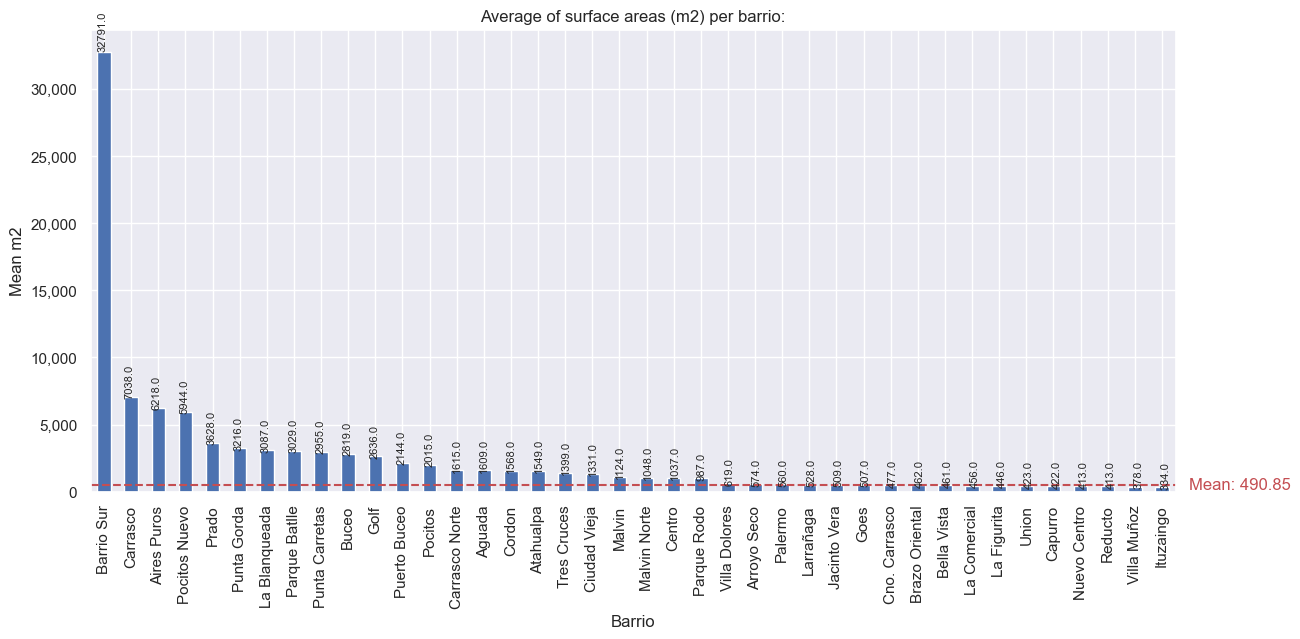

In [209]:
# We change the empty values of the 'surface' column and check that the surface values are integer values:
data_ca['superficie'] = data_ca['superficie'].replace([np.inf, -np.inf], np.nan).fillna(0).astype(float).astype(int)

# Calculates the average of 'usd_value' by 'neighborhood'.
mean_m2 = data_ca.groupby('barrio')['superficie'].mean().round()

# Sort values in descending order
mean_m2 = mean_m2.sort_values(ascending=False)

# Calculates the average of all values
mean = data_ca['superficie'].mean()

# Create a bar chart
fig, ax = plt.subplots(figsize=(14, 6))
mean_valor_usd.plot(kind='bar', ax=ax)

# Adds a horizontal line for the average of all the values
ax.axhline(y=mean, color='r', linestyle='--')

# Adds a label for the stocking line
ax.text(len(mean_valor_usd), mean, f'Mean: {mean:.2f}', color='r', va='center')

# Establece el título y las etiquetas de los ejes
ax.set_title('Average of surface areas (m2) per barrio:')
ax.set_xlabel('Barrio')
ax.set_ylabel('Mean m2')

# Rotate the x-axis labels to vertical
plt.xticks(rotation='vertical')

# Sets the size of the y-axis labels.
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Add the labels of the values in the bars.
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005), rotation=90, fontsize=8)

# Shows the graph
plt.show()

As we can see, even when filtering the sale and rental ads we have ads with very high surface areas, we find that in some neighborhoods they are well above the overall average of the subset of data, which is approximately 490m2. Let's find out what happens with the ads in those neighborhoods with a new subset of data:

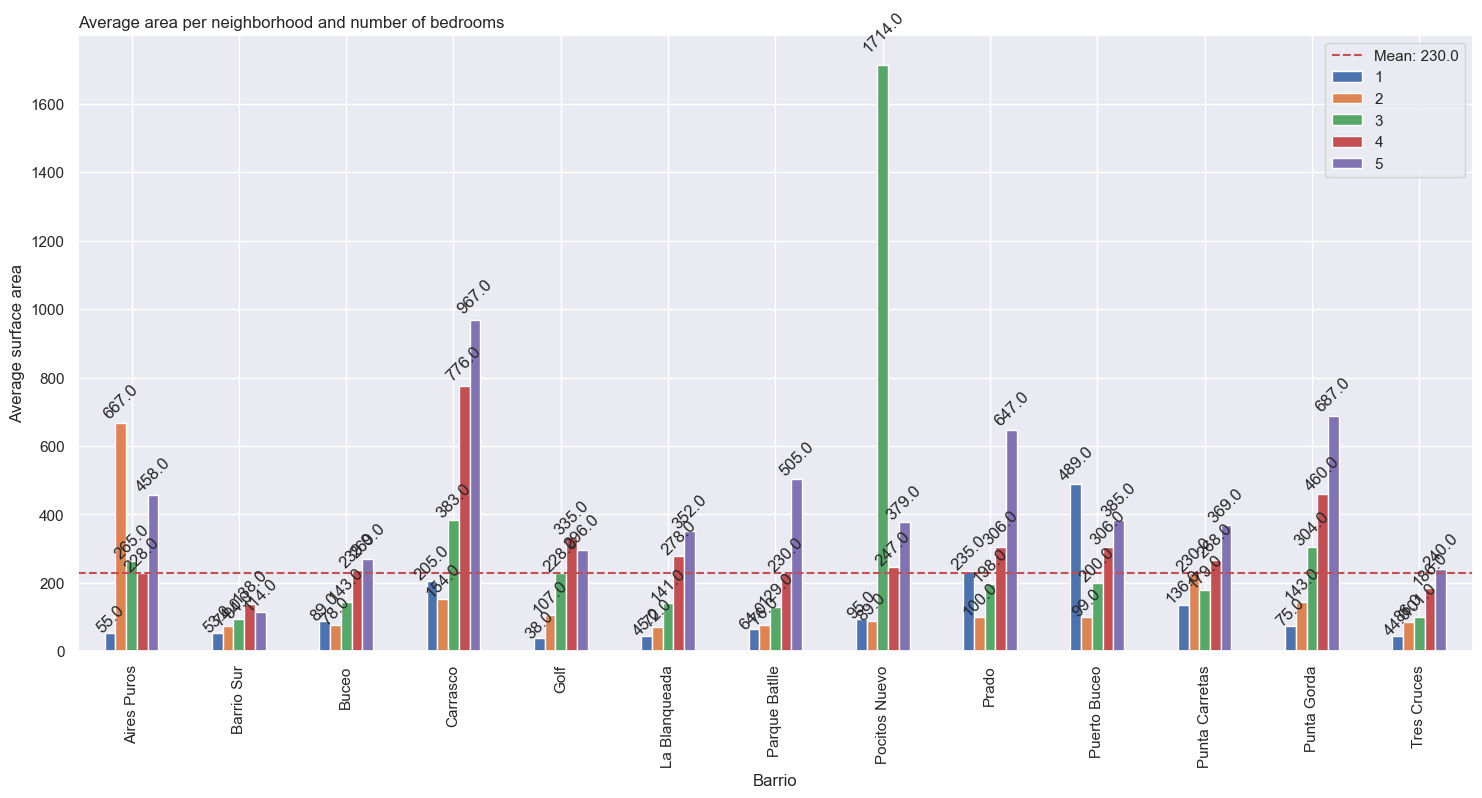

In [210]:
df_check = data_ca

# we filter rows where 'tipo' is 4 or 5
df_check = df_check[df_check['barrio'].isin(['Barrio Sur', 'Pocitos Nuevo', 'Aires Puros', 'Carrasco', 'Buceo', 'Golf',
                                            'La Blanqueada', 'Parque Batlle', 'Prado', 'Puerto Buceo', 'Punta Carretas', 'Punta Gorda', 'Tres Cruces'])]

# We calculate the global average of the surface
mean = df_check['superficie'].mean().round()

# We calculate the average of 'surface area' grouped by 'neighborhoods' and 'type'.
media_ag = df_check.groupby(['barrio', 'dormitorios'])['superficie'].mean().unstack().round()

# We create the bar chart
ax = media_ag.plot(kind='bar', stacked=False, figsize=(18, 8))

# We add the labels to each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height}', (x + width/2, y + height*1.02), ha='center', rotation=45)

# We add a horizontal line for the global average
ax.axhline(y=mean, color='r', linestyle='--', label=f'Mean: {mean}')
plt.legend()

plt.title('Average area per neighborhood and number of bedrooms',None, 'left')
plt.xlabel('Barrio')
plt.ylabel('Average surface area')

# We rotate the x-axis labels by 90 degrees.
plt.xticks(rotation=90)

plt.show()

In [211]:
df_check['superficie'].unique()

array([   130,     30,     85,    249,     58,     10,    580,   1000,
          339,    750,     26,     65,     29,    192,     48,    190,
          260,    168,   6050,    180,     75,     59,     40,     45,
           90,    350,    150,     46,    230,    600,     52,   1350,
          100,    430,     96,    480,     57,     86,    138,     44,
          258,     53,    675,     49,     73,    178,     50,    115,
          210,    117,     92,     76,     37,     66,     55,    330,
           38,   9177,     36,    777,    137,    160,     79,    400,
           98,    380,     54,    203,     64,    231,    305,     43,
          225,     67,    257,    410,    145,     80,    140,     70,
          127,    340,     97,    101,    500,    189,     62,    338,
          132,     63,   2000,    632,    107,     35,    300,    183,
          179,    236,     31,    220,     47,    129,    122,    123,
          154,    170,     60,    255,    240,    277,    133,    353,
      

From the graphical analysis and the sampling of the values for the sample of neighborhoods that far exceed the global average that we calculated at the level of all the neighborhoods, we can see that there are several outliers that far exceed the average of the other neighborhoods. In order to advance with the analysis and thinking about being able to make a prediction, we are interested in not being influenced by those values that are very extreme. We consider it reasonable to place ourselves in values of no more than 1000m2, regardless of the number of bedrooms.

If we make a review of the filters that we consider convenient to carry out the task of this notebook are:
- Establish as a priority the analysis of houses and apartments regardless of the business proposed in the advertisement.
- Filter those properties whose surface area is greater than 1000m2.

We will then proceed to narrow down the data sample:

In [212]:
# We define a new data subset 'data_r' or 'reduced data' to work with from now on:
data_r = data[data['tipo'].isin([4, 5])]

data_r['superficie'] = data_r['superficie'].astype(int)
data_r = data_r[data_r['superficie'] <= 1000]

# Check the filters applied:
print(
    data_r['tipo'].unique(),
    data_r['negocio'].unique(),
    data_r['superficie'].max(),
    data_r['superficie'].min()
)

[4 5] ['Venta' 'Alquiler' 'Alquiler temporario'] 1000 1


C:\Users\andre\AppData\Local\Temp\ipykernel_5460\200629423.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_r['superficie'] = data_r['superficie'].astype(int)


## 4. Projections:

In this section we will address the central objective of this notebook which is to make a projection of the real estate market for the next semester.

In [213]:
data_r.head()

,aviso,superficie,tipo,dormitorios,barrio,negocio,fecha,valor_usd
1,12452693,130,4,3,Punta Carretas,Venta,2021-01-03,380000
2,16660467,75,4,2,Ciudad Vieja,Venta,2021-01-03,129000
3,13853448,30,4,1,Punta Carretas,Venta,2021-01-03,115000
4,15079669,96,4,3,Malvin,Venta,2021-01-03,345000
5,16625327,85,4,2,Puerto Buceo,Alquiler,2021-01-03,1000


We will start with the projection for apartment sales by defining a dataframe and dividing it between training and testing (Train and test respectively):

In [214]:
df_ventas = data_r[data_r['negocio'] == 'Venta']
df_ventas.head()

,aviso,superficie,tipo,dormitorios,barrio,negocio,fecha,valor_usd
1,12452693,130,4,3,Punta Carretas,Venta,2021-01-03,380000
2,16660467,75,4,2,Ciudad Vieja,Venta,2021-01-03,129000
3,13853448,30,4,1,Punta Carretas,Venta,2021-01-03,115000
4,15079669,96,4,3,Malvin,Venta,2021-01-03,345000
6,16609637,249,5,4,Prado,Venta,2021-01-03,380000


In [215]:
df_ventas.dtypes

aviso                  object
superficie              int32
tipo                    int64
dormitorios             int64
barrio                 object
negocio                object
fecha          datetime64[ns]
valor_usd               int32
dtype: object

First, we must prepare our data. We will use: 'superficie', 'tipo', 'dormitorios', 'barrio' as independent variables (X) and 'valor_usd' as our target variable (y).

We must first encode the labels of our categorical variables that are still of type 'str' so that we can reuse their original value at a later time.

In [216]:
# Encodes the categorical variables and stores the correspondence
le = LabelEncoder()
df_ventas['barrio'] = le.fit_transform(df_ventas['barrio'])
barrio_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# To obtain the original neighborhoods, you can use the inverted dictionary.
inv_barrio_mapping = {v: k for k, v in barrio_mapping.items()}

print(inv_barrio_mapping)

{0: 'Aguada', 1: 'Aires Puros', 2: 'Arroyo Seco', 3: 'Atahualpa', 4: 'Barrio Sur', 5: 'Bella Vista', 6: 'Bolivar', 7: 'Brazo Oriental', 8: 'Buceo', 9: 'Capurro', 10: 'Carrasco', 11: 'Carrasco Norte', 12: 'Centro', 13: 'Ciudad Vieja', 14: 'Cno. Carrasco', 15: 'Cordon', 16: 'Goes', 17: 'Golf', 18: 'Ituzaingo', 19: 'Jacinto Vera', 20: 'La Blanqueada', 21: 'La Comercial', 22: 'La Figurita', 23: 'Larrañaga', 24: 'Malvin', 25: 'Malvin Norte', 26: 'Nuevo Centro', 27: 'Palermo', 28: 'Parque Batlle', 29: 'Parque Rodo', 30: 'Pocitos', 31: 'Pocitos Nuevo', 32: 'Prado', 33: 'Prado Norte', 34: 'Puerto Buceo', 35: 'Punta Carretas', 36: 'Punta Gorda', 37: 'Reducto', 38: 'Tres Cruces', 39: 'Union', 40: 'Villa Dolores', 41: 'Villa Muñoz'}


C:\Users\andre\AppData\Local\Temp\ipykernel_5460\1558304399.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ventas['barrio'] = le.fit_transform(df_ventas['barrio'])


In order to perform our prediction we will use the scikit-learn library:

This library offers a variety of resources to apply Machine Learning algorithms.

For our problem given the nature of the number of possibilities (superficie, tipo, dormitorios, barrio) we want to analyze it is convenient to apply a 'Random Forest' regression model.

The documentation can be found in the official site of this library:

https://scikit-learn.org/stable/modules/ensemble.html#forest

"In random forests (In this case RandomForestRegressor), each ensemble tree is constructed from a sample drawn with replacement (i.e., a bootstrap sample) from the training set.
In addition, when splitting each node during tree construction, the best split is found from all input features or from a random subset of size max_features. (See the parameter tuning guidelines for more information).
The goal of these two sources of randomness is to reduce the variance of the forest estimator. In fact, individual decision trees often exhibit high variance and tend to over-fit. Randomness injected into the forests produces decision trees with somewhat disjoint prediction errors. By taking an average of these predictions, some errors may cancel out. Random forests achieve variance reduction by combining several trees, sometimes at the cost of a slight increase in bias. In practice, the reduction in variance is usually significant, resulting in an overall better model."

In [217]:
# Decomposes the 'date' column into numeric components
df_ventas['year'] = df_ventas['fecha'].dt.year
df_ventas['month'] = df_ventas['fecha'].dt.month
df_ventas['day'] = df_ventas['fecha'].dt.day

# Create a column for the year and semester of the following year.
df_ventas['year_next'] = df_ventas['year'] + 1
df_ventas['semestre_next'] = (df_ventas['month'] > 6) + 1

# You can now delete the 'date' column
df_ventas = df_ventas.drop('fecha', axis=1)

# Coding of categorical variables
for col in ['aviso', 'barrio', 'negocio', 'tipo']:
    le = LabelEncoder()
    df_ventas[col] = le.fit_transform(df_ventas[col])

# Splits data into training and test sets
X = df_ventas.drop('valor_usd', axis=1)
y = df_ventas['valor_usd']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a regression model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Makes predictions and evaluates the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Error cuadrático medio: {mse}, y el valor de r2: {r2}.')

C:\Users\andre\AppData\Local\Temp\ipykernel_5460\335234147.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ventas['year'] = df_ventas['fecha'].dt.year
C:\Users\andre\AppData\Local\Temp\ipykernel_5460\335234147.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ventas['month'] = df_ventas['fecha'].dt.month
C:\Users\andre\AppData\Local\Temp\ipykernel_5460\335234147.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

Error cuadrático medio: 5883235244.856399, y el valor de r2: 0.7822991035617177.


In [218]:
# Create a new DataFrame with our predictions:
df_pred = pd.DataFrame(y_pred, columns=['prediccion'], index=X_test.index)

# Combines the predictions with the original DataFrame
df_merged_v = pd.merge(df_ventas, df_pred, left_index=True, right_index=True)

df_merged_v['prediccion'] = df_merged_v['prediccion'].astype(int)

df_merged_v.head()

,aviso,superficie,tipo,dormitorios,barrio,negocio,valor_usd,year,month,day,year_next,semestre_next,prediccion
25,1108,87,0,2,15,0,153000,2021,1,3,2022,1,160674
40,3402,70,0,2,15,0,152900,2021,1,3,2022,1,142037
41,2757,320,1,3,24,0,320000,2021,1,3,2022,1,345270
42,4748,180,0,3,10,0,520000,2021,1,3,2022,1,663316
46,8244,112,0,3,30,0,330000,2021,1,3,2022,1,334600


In [219]:
# Create a new column 'barrio_nom' with the original names of the neighborhoods.
df_merged_v['barrio_nom'] = df_merged_v['barrio'].map(inv_barrio_mapping)
df_merged_v.head()

,aviso,superficie,tipo,dormitorios,barrio,negocio,valor_usd,year,month,day,year_next,semestre_next,prediccion,barrio_nom
25,1108,87,0,2,15,0,153000,2021,1,3,2022,1,160674,Cordon
40,3402,70,0,2,15,0,152900,2021,1,3,2022,1,142037,Cordon
41,2757,320,1,3,24,0,320000,2021,1,3,2022,1,345270,Malvin
42,4748,180,0,3,10,0,520000,2021,1,3,2022,1,663316,Carrasco
46,8244,112,0,3,30,0,330000,2021,1,3,2022,1,334600,Pocitos


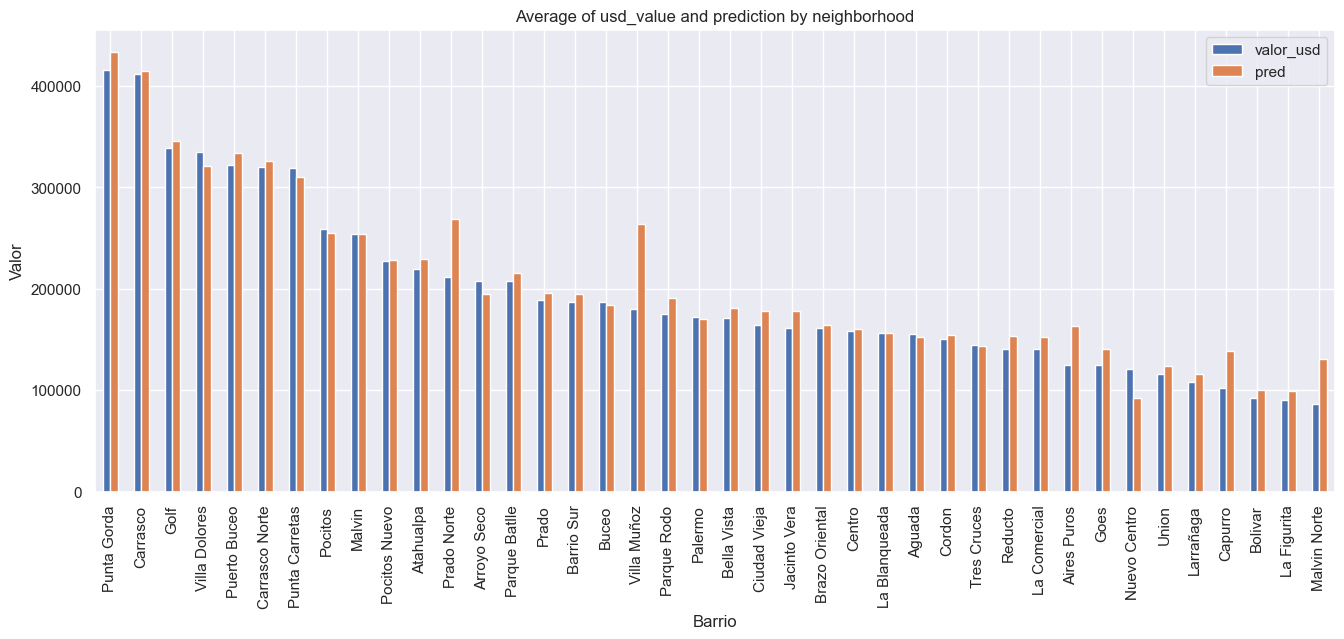

In [220]:
# Calculates the average of the 'usd_value' and the 'prediction' for each 'neighborhood'.
mean_valor_usd = df_merged_v.groupby('barrio_nom')['valor_usd'].mean()
mean_pred = df_merged_v.groupby('barrio_nom')['prediccion'].mean()

# Create a DataFrame with the results
df_grafico = pd.DataFrame({'valor_usd': mean_valor_usd, 'pred': mean_pred})

# Sort the values in descending order by 'usd_value'.
df_grafico = df_grafico.sort_values(by='valor_usd', ascending=False)

# Create the chart
df_grafico.plot(kind='bar', figsize=(16, 6))
plt.title('Average of usd_value and prediction by neighborhood')
plt.ylabel('Valor')
plt.xlabel('Barrio')
plt.show()

As we can see the average values in U$D per neighborhood when the business is for sale for the first half of 2022 has some interesting implications:

For example: neighborhoods such as Carrasco, Carrasco Norte, Punta Gorda, Golf have a slightly upward trend which makes them present themselves as attractive options being the most expensive of the dataset. On the other hand, the option with the highest price appreciation is Prado Norte and Villa Muñoz, making it a priori the most attractive option according to the prediction.

We will delve inside what happens in Prado Norte and Villa Muñoz by number of bedrooms:

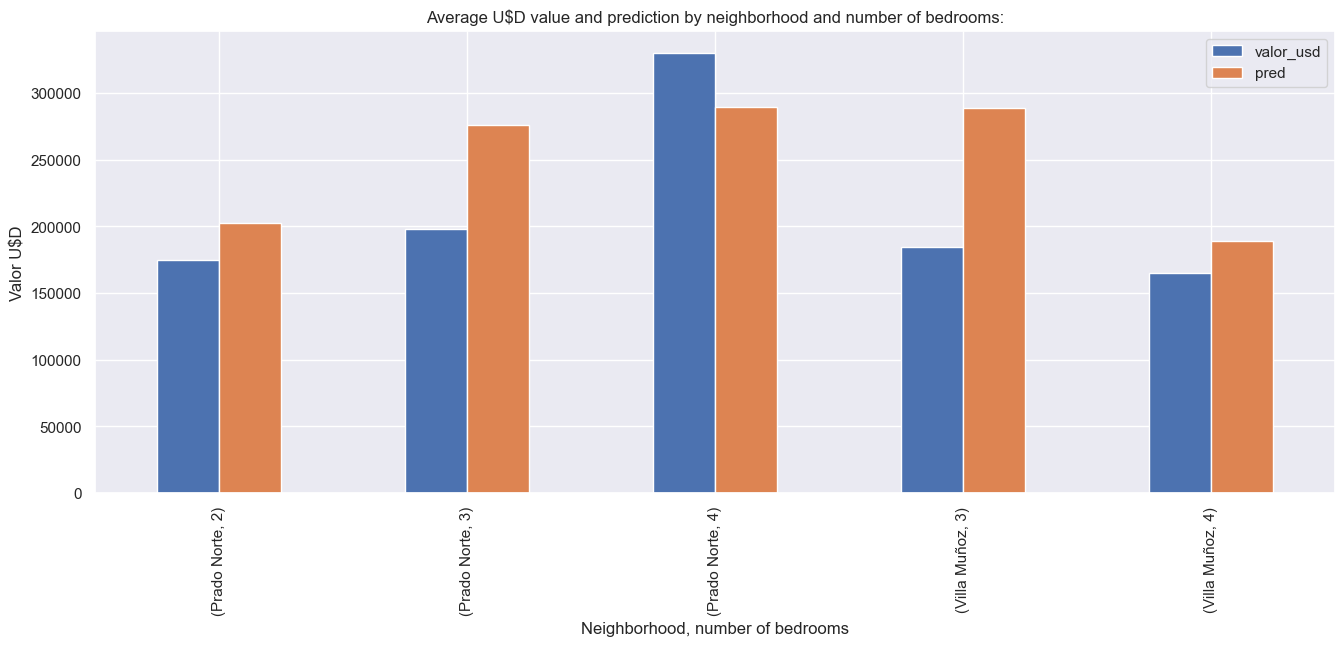

In [221]:
df_check = df_merged_v[df_merged_v['barrio_nom'].isin(['Prado Norte', 'Villa Muñoz'])]

mean_valor_usd = df_check.groupby(['barrio_nom', 'dormitorios'])['valor_usd'].mean()
mean_pred = df_check.groupby(['barrio_nom', 'dormitorios'])['prediccion'].mean()

# Create a DataFrame with the results
df_grafico = pd.DataFrame({'valor_usd': mean_valor_usd, 'pred': mean_pred})

# Create the chart
df_grafico.plot(kind='bar', figsize=(16, 6))
plt.title('Average U$D value and prediction by neighborhood and number of bedrooms:')
plt.ylabel('Valor U$D')
plt.xlabel('Neighborhood, number of bedrooms')
plt.show()

We can see in this case that within these neighborhoods that present very auspicious predictions for the first half of 2022, it is in the 3-bedroom format where there is the highest sales price in U$D. We can take into account this pair of neighborhoods and bedrooms as an interesting option to consider in the conclusions, however it will be interesting to analyze what happens when we look at the average area in m2 per number of bedrooms:

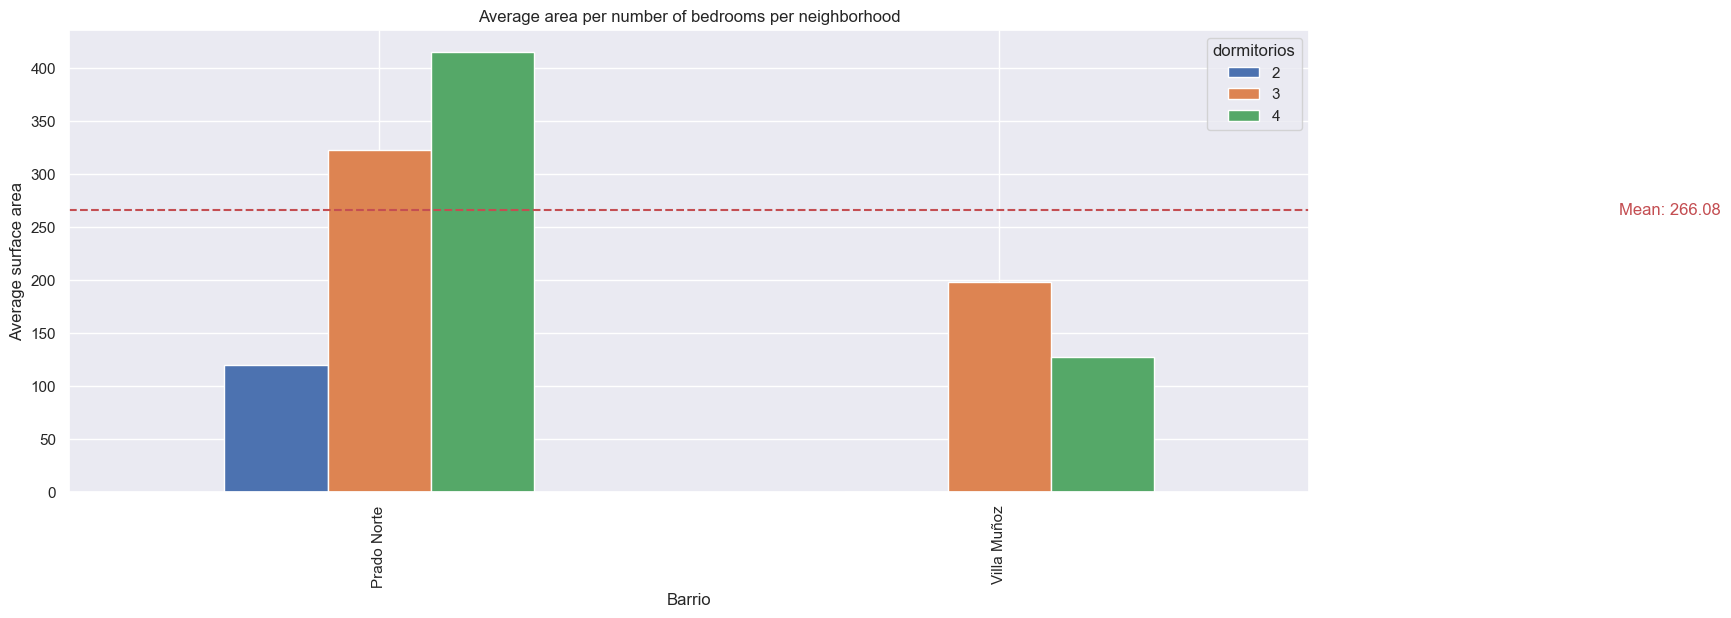

In [222]:
# Calculates the average of 'surface area' by 'neighborhood_nom' and 'bedrooms'.
mean_superficie = df_check.groupby(['barrio_nom', 'dormitorios'])['superficie'].mean()

# Unstack the index to have 'neighborhood_nom' and 'bedrooms' as columns
df_grafico = mean_superficie.unstack()

# Calculates the average of all values
mean = df_check['superficie'].mean()

# Calculate the average 'surface area' for each neighborhood.
mean_superficie_barrio = df_check.groupby('barrio_nom')['superficie'].mean()

# Sorts the neighborhoods by the average 'surface area'.
orden_barrios = mean_superficie_barrio.sort_values(ascending=False).index

# Reorder df_grafico according to the order of the neighborhoods
df_grafico = df_grafico.loc[orden_barrios]

# Create the chart
fig, ax = plt.subplots(figsize=(16, 6))
df_grafico.plot(kind='bar', ax=ax)
ax.axhline(y=mean, color='r', linestyle='--')

# Adds a label for the stocking line
ax.text(len(df_grafico), mean, f'Mean: {mean:.2f}', color='r', va='center')

# Sets the title and labels of the axes.
ax.set_title('Average area per number of bedrooms per neighborhood')
ax.set_xlabel('Barrio')
ax.set_ylabel('Average surface area')

# Rotate the x-axis labels to vertical
plt.xticks(rotation='vertical')

# Sets the size of the y-axis labels.
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Shows the graph
plt.show()

We can see that Villa Muñoz could be a very profitable option since it had good predictions for 2022 and the average area for 3 and 4 bedrooms is below the general average of this subset of neighborhoods.

Now it will be our turn to analyze the neighborhoods that a priori had the most expensive ads:

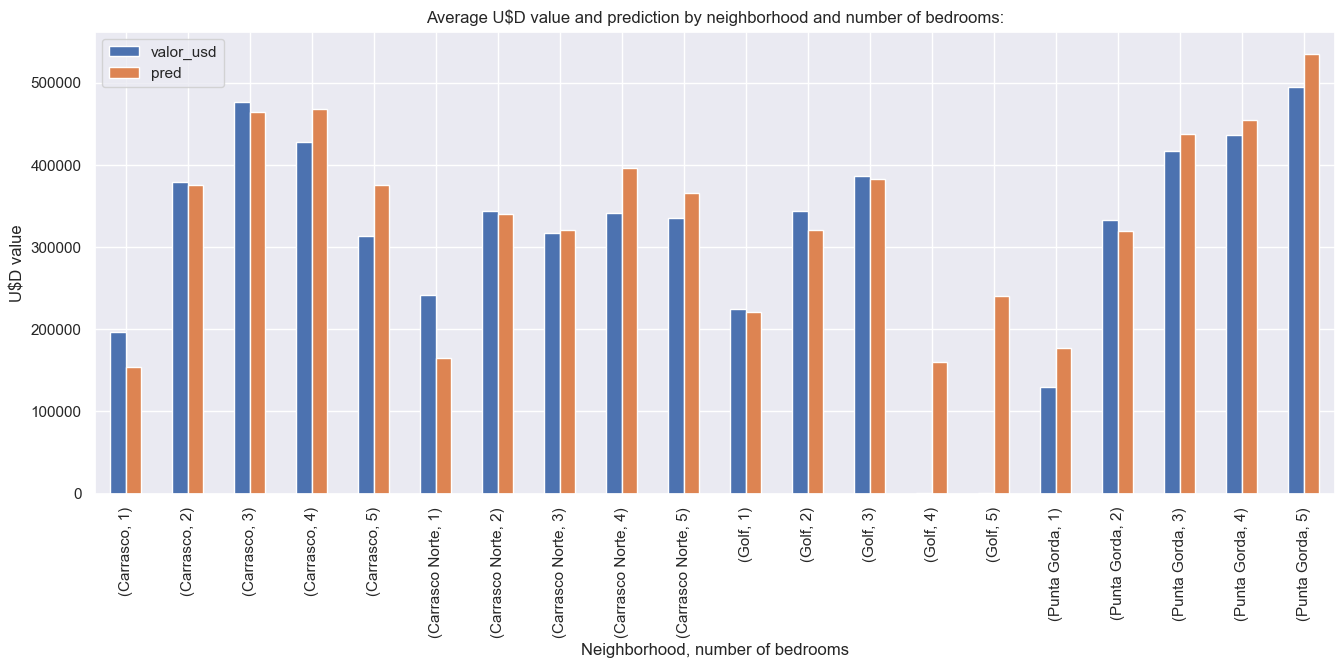

In [223]:
df_check = df_merged_v[df_merged_v['barrio_nom'].isin(['Carrasco','Carrasco Norte', 'Golf', 'Punta Gorda'])]

mean_valor_usd = df_check.groupby(['barrio_nom', 'dormitorios'])['valor_usd'].mean()
mean_pred = df_check.groupby(['barrio_nom', 'dormitorios'])['prediccion'].mean()

# Create a DataFrame with the results
df_grafico = pd.DataFrame({'valor_usd': mean_valor_usd, 'pred': mean_pred})

# Shows the graph
df_grafico.plot(kind='bar', figsize=(16, 6))
plt.title('Average U$D value and prediction by neighborhood and number of bedrooms:')
plt.ylabel('U$D value')
plt.xlabel('Neighborhood, number of bedrooms')
plt.show()

We will now analyze what happens when we look at the average area in m2 per bedroom per capita in these neighborhoods:

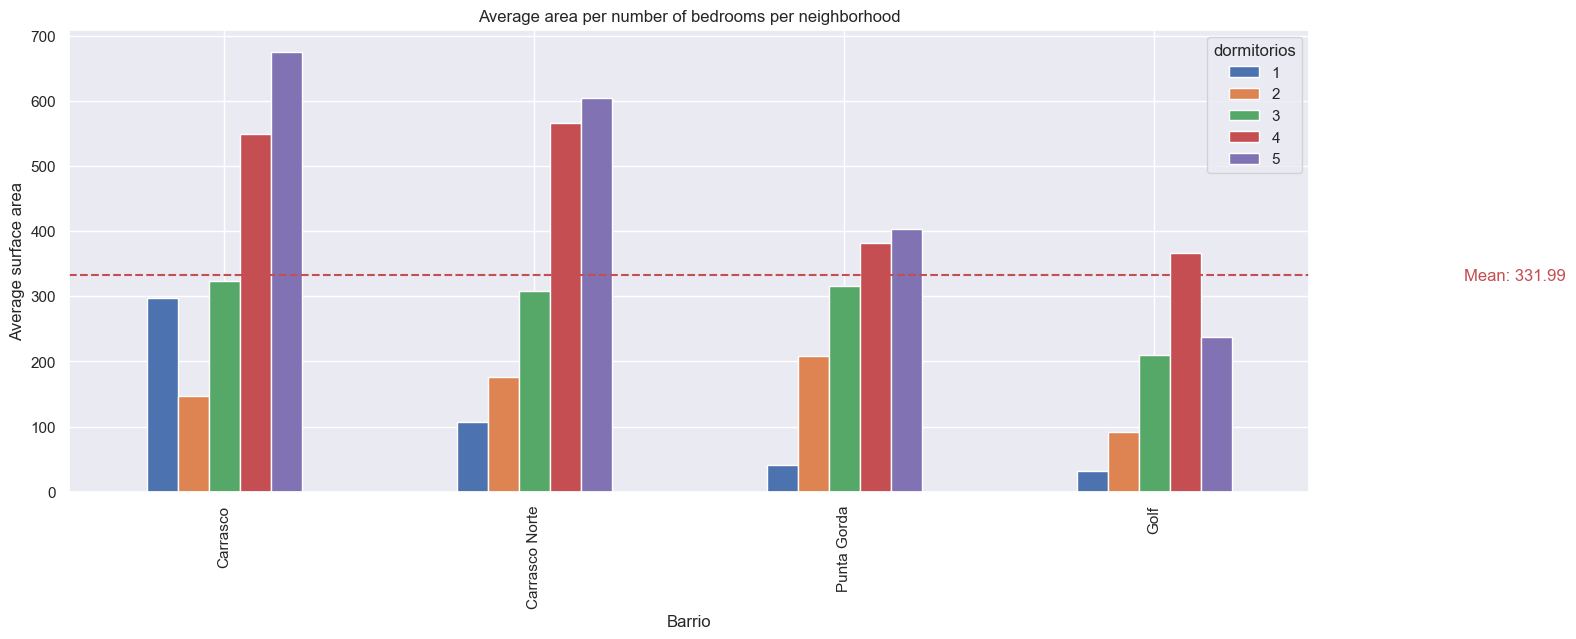

In [224]:
# Calculates the average of 'surface area' by 'neighborhood_nom' and 'bedrooms'.
mean_superficie = df_check.groupby(['barrio_nom', 'dormitorios'])['superficie'].mean()

# Unstack the index to have 'neighborhood_nom' and 'bedrooms' as columns
df_grafico = mean_superficie.unstack()

# Calculates the average of all values
mean = df_check['superficie'].mean()

# Calculate the average 'surface area' for each neighborhood.
mean_superficie_barrio = df_check.groupby('barrio_nom')['superficie'].mean()

# Sorts the neighborhoods by the average 'surface area'.
orden_barrios = mean_superficie_barrio.sort_values(ascending=False).index

# Reorder df_grafico according to the order of the neighborhoods
df_grafico = df_grafico.loc[orden_barrios]

# Create the chart
fig, ax = plt.subplots(figsize=(16, 6))
df_grafico.plot(kind='bar', ax=ax)

# Adds a horizontal line for the average of all the values
ax.axhline(y=mean, color='r', linestyle='--')

# Adds a label for the stocking line
ax.text(len(df_grafico), mean, f'Mean: {mean:.2f}', color='r', va='center')

# Establece el título y las etiquetas de los ejes
ax.set_title('Average area per number of bedrooms per neighborhood')
ax.set_xlabel('Barrio')
ax.set_ylabel('Average surface area')

# Rotate the x-axis labels to vertical
plt.xticks(rotation='vertical')

# Sets the size of the y-axis labels.
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Shows the graph
plt.show()

Now if we analyze the neighborhood-quantity of bedrooms combinations, which a priori had the highest average published U$D value, we have that:
- In Carrasco and Carrasco Norte the most attractive projections are in 4 and more than 4 bedrooms. There seems to be a positive relationship between the sales value, the total surface in m2 and the number of bedrooms.
- In Golf we see how the model predicted prices for 4 and more than 4 bedrooms without having ads against which to contrast.
- In Punta Gorda from 3 bedrooms onwards the projections are better than the values published in the dataset ads. However, if we look at the case of 1 bedroom with a prediction higher than the value_usd of the ad in 2021 and the average surface in m2 is not very large, it can be a very profitable option.

Regarding sales we could conclude that the sales price projections within the most expensive neighborhoods of the studied municipalities are attractive for 2022 and are in properties with 3 to more than 4 bedrooms in general. While in the case of the two "surprise" neighborhoods (Prado Norte and Villa Muñoz) we have that the most attractive options based on the projection would be in 3 bedrooms in both neighborhoods.

Now we will analyze what happens in the rental market, for this we will do the same procedure defining a dataset for Rentals and applying the same model.

In [225]:
# We define a dataframe for the rentals:
df_alquileres = data_r[data_r['negocio'] == 'Alquiler']

# Encodes the categorical variables and stores the correspondence
le = LabelEncoder()
df_alquileres['barrio'] = le.fit_transform(df_alquileres['barrio'])
barrio_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# To obtain the original neighborhoods, you can use the inverted dictionary.
inv_barrio_mapping = {v: k for k, v in barrio_mapping.items()}

print(inv_barrio_mapping)

{0: 'Aguada', 1: 'Aires Puros', 2: 'Arroyo Seco', 3: 'Atahualpa', 4: 'Barrio Sur', 5: 'Bella Vista', 6: 'Brazo Oriental', 7: 'Buceo', 8: 'Capurro', 9: 'Carrasco', 10: 'Carrasco Norte', 11: 'Centro', 12: 'Ciudad Vieja', 13: 'Cno. Carrasco', 14: 'Cordon', 15: 'Goes', 16: 'Golf', 17: 'Ituzaingo', 18: 'Jacinto Vera', 19: 'La Blanqueada', 20: 'La Comercial', 21: 'La Figurita', 22: 'Larrañaga', 23: 'Malvin', 24: 'Malvin Norte', 25: 'Nuevo Centro', 26: 'Palermo', 27: 'Parque Batlle', 28: 'Parque Rodo', 29: 'Pocitos', 30: 'Pocitos Nuevo', 31: 'Prado', 32: 'Puerto Buceo', 33: 'Punta Carretas', 34: 'Punta Gorda', 35: 'Reducto', 36: 'Tres Cruces', 37: 'Union', 38: 'Villa Dolores', 39: 'Villa Muñoz'}


C:\Users\andre\AppData\Local\Temp\ipykernel_5460\2612068061.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alquileres['barrio'] = le.fit_transform(df_alquileres['barrio'])


In [226]:
# Decomposes the 'date' column into numeric components
df_alquileres['year'] = df_alquileres['fecha'].dt.year
df_alquileres['month'] = df_alquileres['fecha'].dt.month
df_alquileres['day'] = df_alquileres['fecha'].dt.day

# Create a column for the year and semester of the following year.
df_alquileres['year_next'] = df_alquileres['year'] + 1
df_alquileres['semestre_next'] = (df_alquileres['month'] > 6) + 1

# You can now delete the 'date' column
df_alquileres = df_alquileres.drop('fecha', axis=1)

# Coding of categorical variables
for col in ['aviso', 'barrio', 'negocio', 'tipo']:
    le = LabelEncoder()
    df_alquileres[col] = le.fit_transform(df_alquileres[col])

# Splits data into training and test sets
X = df_alquileres.drop('valor_usd', axis=1)
y = df_alquileres['valor_usd']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a regression model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Makes predictions and evaluates the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean square error: {mse}, and the value of r2: {r2}.')

C:\Users\andre\AppData\Local\Temp\ipykernel_5460\521362334.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alquileres['year'] = df_alquileres['fecha'].dt.year
C:\Users\andre\AppData\Local\Temp\ipykernel_5460\521362334.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alquileres['month'] = df_alquileres['fecha'].dt.month
C:\Users\andre\AppData\Local\Temp\ipykernel_5460\521362334.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Mean square error: 346027079.3108691, and the value of r2: -0.01271470521564666.


In [227]:
# Create a new DataFrame with the predictions.
df_pred = pd.DataFrame(y_pred, columns=['prediccion'], index=X_test.index)

# Combines the predictions with the original DataFrame
df_merged_a = pd.merge(df_alquileres, df_pred, left_index=True, right_index=True)

df_merged_a['prediccion'] = df_merged_a['prediccion'].astype(int)

# Create a new column 'barrio_nom' with the original names of the neighborhoods.
df_merged_a['barrio_nom'] = df_merged_a['barrio'].map(inv_barrio_mapping)

df_merged_a.head()

,aviso,superficie,tipo,dormitorios,barrio,negocio,valor_usd,year,month,day,year_next,semestre_next,prediccion,barrio_nom
49,1020,45,0,1,36,0,129800,2021,1,3,2022,1,518,Tres Cruces
65,1886,69,0,2,29,0,569,2021,1,3,2022,1,1474,Pocitos
68,555,115,0,2,10,0,1390,2021,1,3,2022,1,1434,Carrasco Norte
75,1465,50,0,2,11,0,462,2021,1,3,2022,1,516,Centro
80,801,440,1,5,29,0,3900,2021,1,3,2022,1,3824,Pocitos


We will begin the graphical analysis as we did in the analysis of the sales ad predictions, first at the general level by identifying neighborhoods that stand out from the rest in terms of the predictions of the model and then go on to analyze what happens within those neighborhoods in terms of the number of bedrooms.

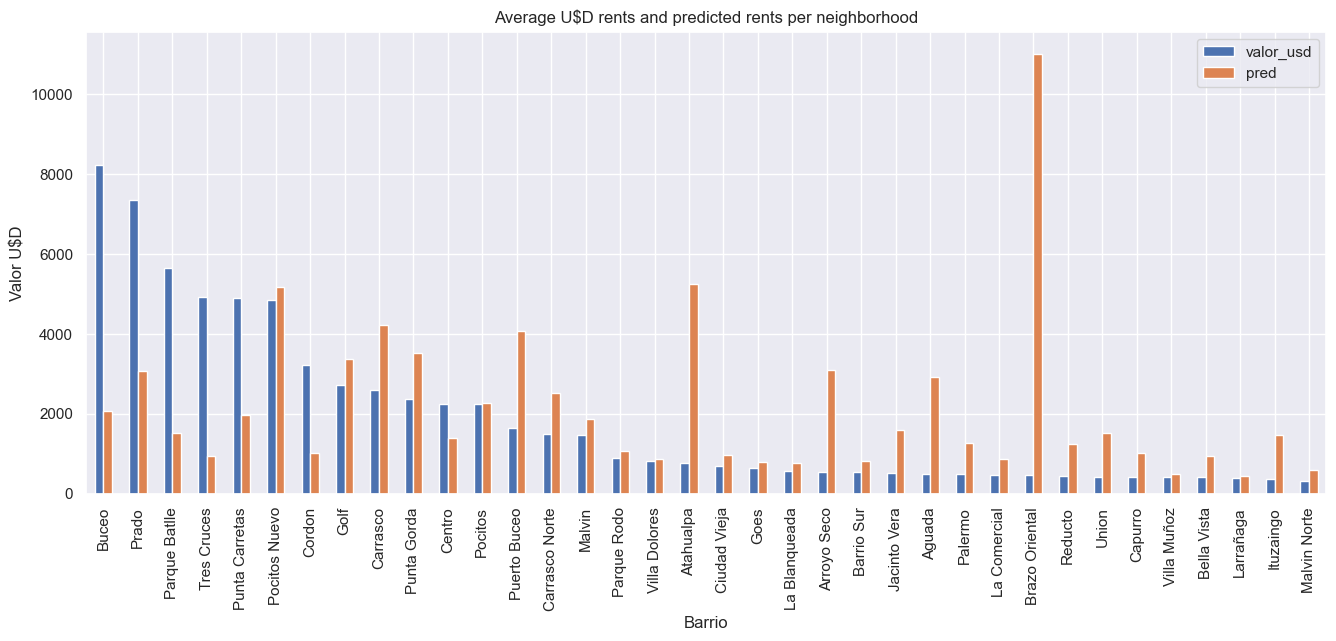

In [228]:
# Calculates the average of the 'usd_value' and the 'prediction' for each 'neighborhood'.
mean_valor_usd = df_merged_a.groupby('barrio_nom')['valor_usd'].mean()
mean_pred = df_merged_a.groupby('barrio_nom')['prediccion'].mean()

# Create a DataFrame with the results
df_grafico = pd.DataFrame({'valor_usd': mean_valor_usd, 'pred': mean_pred})

# Sort the values in descending order by 'usd_value'.
df_grafico = df_grafico.sort_values(by='valor_usd', ascending=False)

# Sort the values in descending order by 'usd_value'.
df_grafico = df_grafico.sort_values(by='valor_usd', ascending=False)

# Create the chart
df_grafico.plot(kind='bar', figsize=(16, 6))
plt.title('Average U$D rents and predicted rents per neighborhood')
plt.ylabel('Valor U$D')
plt.xlabel('Barrio')
plt.show()

On this occasion we see that the neighborhoods that have predictions that are well above the 2021 warnings are: Aguada, Arroyo Seco, Atahualpa, Brazo Oriental, Carrasco, Golf and Puerto Buceo. We see that Carrasco, Golf and Puerto Buceo repeat as attractive options once again, as was the case in the U$D sales price predictions.

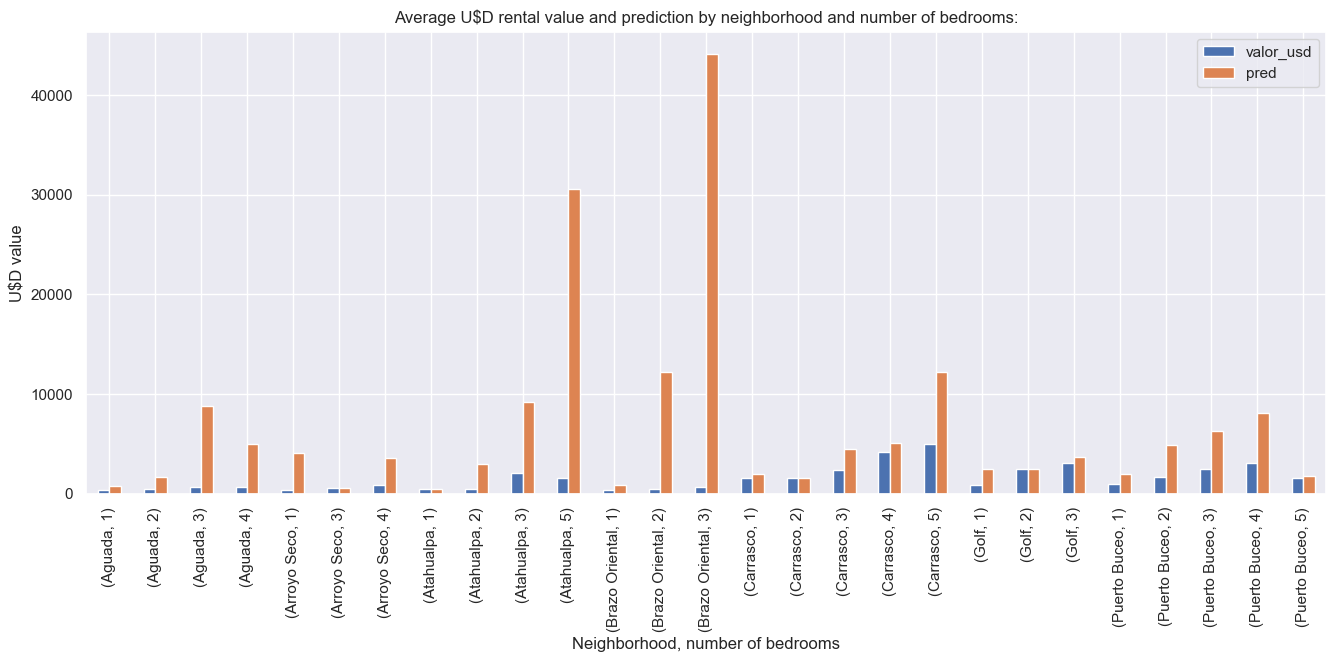

In [229]:
df_check = df_merged_a[df_merged_a['barrio_nom'].isin(['Aguada', 'Arroyo Seco', 'Atahualpa', 'Brazo Oriental', 'Carrasco', 'Golf', 'Puerto Buceo'])]

mean_valor_usd = df_check.groupby(['barrio_nom', 'dormitorios'])['valor_usd'].mean()
mean_pred = df_check.groupby(['barrio_nom', 'dormitorios'])['prediccion'].mean()

# Create a DataFrame with the results
df_grafico = pd.DataFrame({'valor_usd': mean_valor_usd, 'pred': mean_pred})

# Create the chart
df_grafico.plot(kind='bar', figsize=(16, 6))
plt.title('Average U$D rental value and prediction by neighborhood and number of bedrooms:')
plt.ylabel('U$D value')
plt.xlabel('Neighborhood, number of bedrooms')
plt.show()

If we analyze what is happening within the most dynamic neighborhoods of the rental projection, we have that the options of 3 bedrooms and up are the most attractive, especially in Brazo Oriental (3 bedrooms) and Atahualpa (more than 4 bedrooms). Likewise, in Puerto Buceo all rental options present auspicious options for the first half of 2022. In particular, both Carrasco, Golf and Puerto Buceo show a very marked upward trend in their rental prices as we move towards proposals with more bedrooms.

We will analyze the neighborhoods with the best prediction by observing what happens in the distribution of surface area in m2 by number of bedrooms, in particular we want to corroborate that the prediction made for Atahualpa and Eastern Arm has some relationship with the surface area in m2 that explains this prediction:

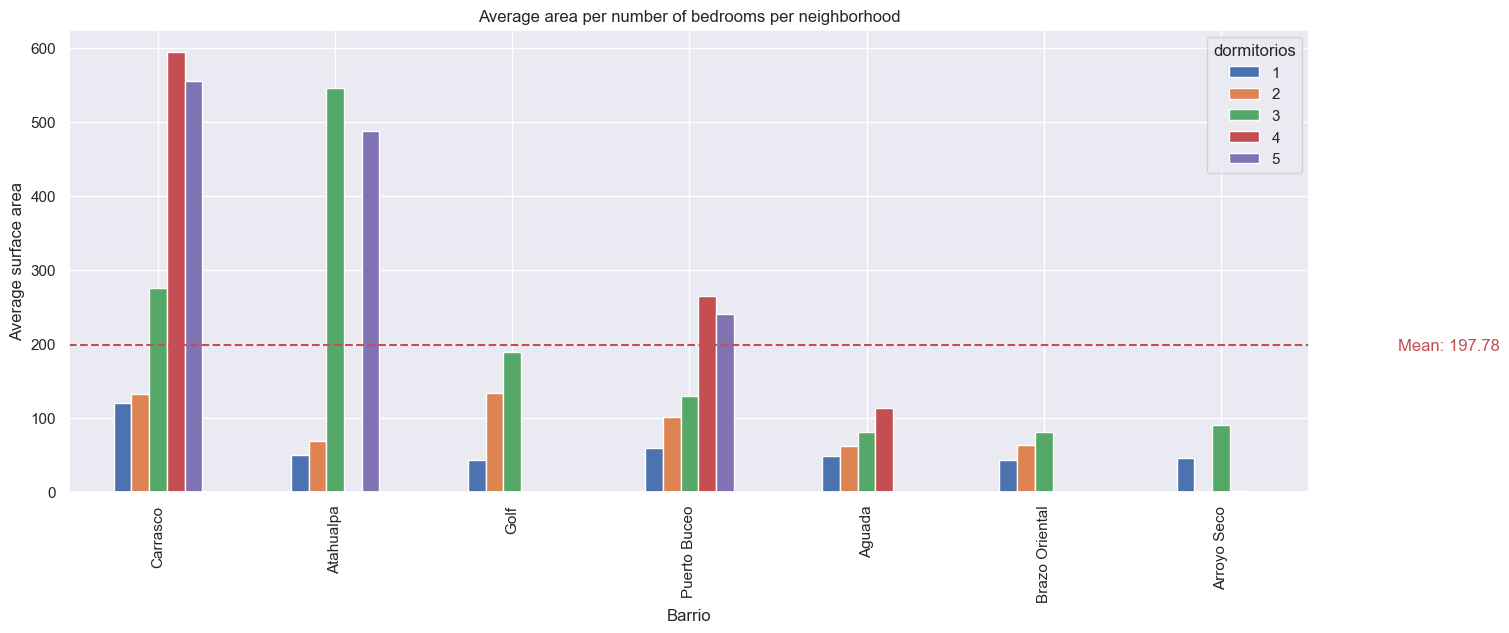

In [230]:
# Calculates the average of 'surface area' by 'neighborhood_nom' and 'bedrooms'.
mean_superficie = df_check.groupby(['barrio_nom', 'dormitorios'])['superficie'].mean()

# Unstack the index to have 'neighborhood_nom' and 'bedrooms' as columns
df_grafico = mean_superficie.unstack()

# Calculates the average of all values
mean = df_check['superficie'].mean()

# Calculate the average 'surface area' for each neighborhood.
mean_superficie_barrio = df_check.groupby('barrio_nom')['superficie'].mean()

# Sorts the neighborhoods by the average 'surface area'.
orden_barrios = mean_superficie_barrio.sort_values(ascending=False).index

# Reorder df_grafico according to the order of the neighborhoods
df_grafico = df_grafico.loc[orden_barrios]

# Create the chart
fig, ax = plt.subplots(figsize=(16, 6))
df_grafico.plot(kind='bar', ax=ax)

# Adds a horizontal line for the average of all the values
ax.axhline(y=mean, color='r', linestyle='--')

# Adds a label for the stocking line
ax.text(len(df_grafico), mean, f'Mean: {mean:.2f}', color='r', va='center')

# Sets the title and labels of the axes.
ax.set_title('Average area per number of bedrooms per neighborhood')
ax.set_xlabel('Barrio')
ax.set_ylabel('Average surface area')

# Rotate the x-axis labels to vertical
plt.xticks(rotation='vertical')

# Sets the size of the y-axis labels.
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Shows the graph
plt.show()

Of the most attractive segments of the average price in U$D for rent we have that the most profitable per m2 could be Puerto del Diving since it doubles in almost all cases its prediction for number of bedrooms and it is one of the neighborhoods with averages of m2 where up to 3 bedrooms are below the global average of this subset of data.

On the other hand, we can conclude that the predictions for Atahualpra and Brazo Oriental are not entirely reliable. Since in the case of Atahualpa the model may (or may not) have observed that the value of surface area in m2 was high and thus assigned a high rental price for the following semester. If we look at Brazo Oriental it is even more disconcerting because the average of the surface areas of the ads for Brazo Oriental do not reach the average of the subset of neighborhoods chosen to analyze here, so there is no direct relationship between surface area in m2 and the published price of the ad that could give us a guideline as to why the model's projection was so high. That is why we will discard these cases as attractive options.

This may indicate that if someone is focused on profitability per m2 Puerto Buceo may be an interesting option.

Now we will analyze the set of neighborhoods whose prediction was well below the value published in the advertisements in 2021:

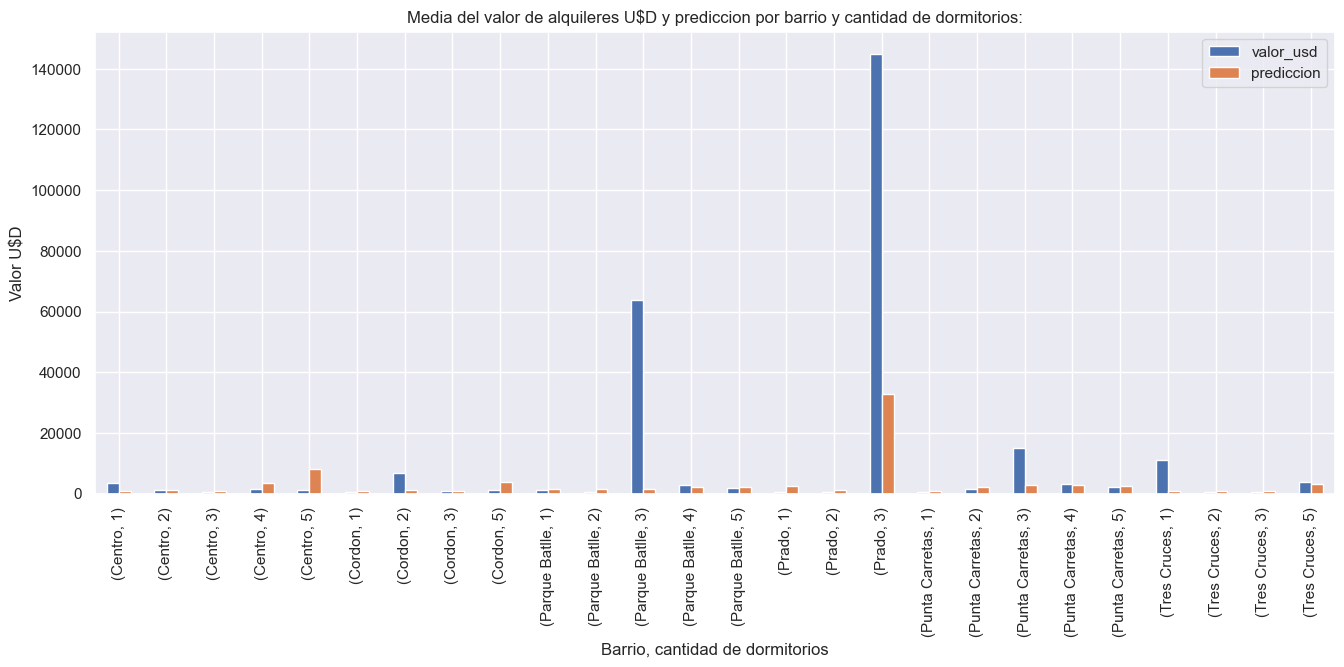

In [231]:
df_check = df_merged_a[df_merged_a['barrio_nom'].isin(['Centro', 'Cordon', 'Parque Batlle', 'Prado', 'Punta Carretas', 'Tres Cruces'])]

mean_valor_usd = df_check.groupby(['barrio_nom', 'dormitorios'])['valor_usd'].mean()
mean_pred = df_check.groupby(['barrio_nom', 'dormitorios'])['prediccion'].mean()

# Create a DataFrame with the results
df_grafico = pd.DataFrame({'valor_usd': mean_valor_usd, 'prediccion': mean_pred})

# Create the chart
df_grafico.plot(kind='bar', figsize=(16, 6))
plt.title('Media del valor de alquileres U$D y prediccion por barrio y cantidad de dormitorios:')
plt.ylabel('Valor U$D')
plt.xlabel('Barrio, cantidad de dormitorios')
plt.show()

Finally, if we analyze the neighborhoods that have lower predictions with respect to the advertisements published in 2021, we find that Parque Batlle and Prado are the ones with the lowest predictions, both in terms of 3-bedroom advertisements. On the other hand we see that in Centro, Tres Cruces and Cordon when we look at 1 bedroom, 1 bedroom and 2 bedroom alternatives respectively, we have the same behavior but the value of the options was much lower than in the neighborhoods mentioned above. For the rest of the bedroom options in the center, the projections are auspicious or at least match the 2021 announcements.

Finally, it remains to analyze what happens with these neighborhoods in terms of square footage per number of bedrooms:

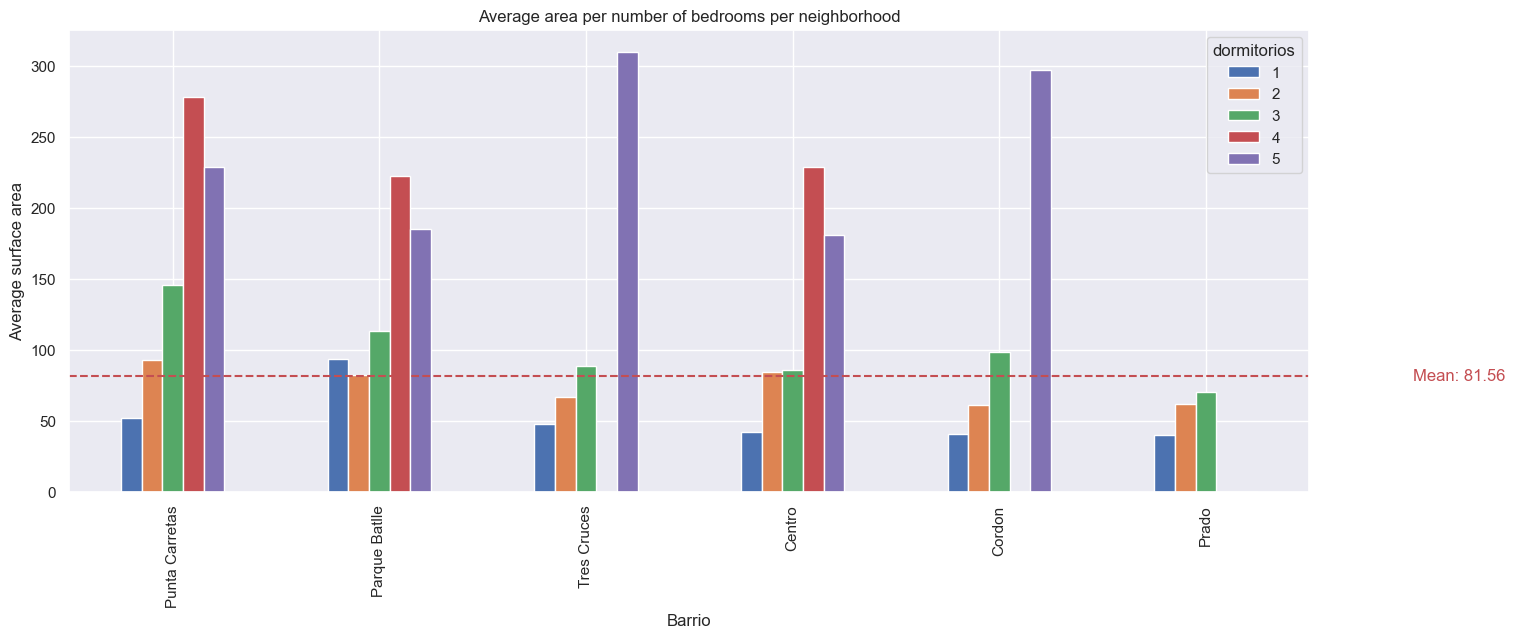

In [232]:
# Calculates the average of 'surface area' by 'neighborhood_nom' and 'bedrooms'.
mean_superficie = df_check.groupby(['barrio_nom', 'dormitorios'])['superficie'].mean()

# Unstack the index to have 'neighborhood_nom' and 'bedrooms' as columns
df_grafico = mean_superficie.unstack()

# Calculates the average of all values
mean = df_check['superficie'].mean()

# Calculate the average 'surface area' for each neighborhood.
mean_superficie_barrio = df_check.groupby('barrio_nom')['superficie'].mean()

# Sorts the neighborhoods by the average 'surface area'.
orden_barrios = mean_superficie_barrio.sort_values(ascending=False).index

# Reorder df_grafico according to the order of the neighborhoods
df_grafico = df_grafico.loc[orden_barrios]

# Create the chart
fig, ax = plt.subplots(figsize=(16, 6))
df_grafico.plot(kind='bar', ax=ax)

# Adds a horizontal line for the average of all the values
ax.axhline(y=mean, color='r', linestyle='--')

# Adds a label for the stocking line
ax.text(len(df_grafico), mean, f'Mean: {mean:.2f}', color='r', va='center')

# Sets the title and labels of the axes.
ax.set_title('Average area per number of bedrooms per neighborhood')
ax.set_xlabel('Barrio')
ax.set_ylabel('Average surface area')

# Rotate the x-axis labels to vertical
plt.xticks(rotation='vertical')

# Sets the size of the y-axis labels.
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Shows the graph
plt.show()

In this sample that we selected where their prediction was lower than the price of the advertisement in 2021, we have that Parque Battle has, regardless of the number of bedrooms, areas on average higher than the average of this sub-set of neighborhoods. Recall that Parque Batlle was one of the most surprising neighborhoods for having low predictions. We can also see that in the Prado neighborhood, the ads are from 1 to 3 bedrooms and in no case reach the average area of the subset of neighborhoods with "bad" predictions.

From these two graphical analyses we cannot draw clear conclusions as to what may be happening with the future prediction of these neighborhoods, what we can establish is that the surface area and number of bedrooms would not be the determining factor for having a low average rental price prediction value, since the surface areas of this subset of data are very similar, particularly the 3 neighborhoods that have up to 4 bedrooms have relatively similar surface areas in m2.

## Conclusions:

In this notebook we have made a brief analysis of the Uruguayan real estate market in 2021, as well as a price projection for the first half of 2022.

We have performed an ETL process and data analysis to better understand the reality of the market and thus project prices taking into account the most relevant variables of the dataset provided.

At a general level, we analyzed the sales and rental ads for the municipalities B, C, CH and E. We found that the most attractive options to sell or rent in U$D value are in the most expensive neighborhoods of those municipalities, understanding as attractive option those in which the average of the ads in the model prediction exceeds the average value of the ads published in 2021.

We also note that according to our prediction there are neighborhoods such as Parque Batlle and Prado that have segments where it would not be very convenient to invest if you want to rent a property (case of 3 bedrooms).

With these insights is that we conclude the analysis, leaving the door open to deepen in another instance if we add additional information or if we intend to exploit other variables already existing in this dataset.